In [13]:
import time
import math
import random
import numpy as np
from scipy.stats import norm
import pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import glob
from functools import partial
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image
from tqdm import tqdm
from torch.nn.modules.upsampling import Upsample
import torch.autograd as autograd
print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(os.environ.get('NUMEXPR_MAX_THREADS', 'Not set'))
os.environ['NUMEXPR_MAX_THREADS'] = str(24)
from torch.nn.parallel import DataParallel

2.0.1
Using device: cuda:0
Not set


In [14]:
class DatasetLoader(object):

    def __init__(self, path, batch_size, transform=None):
        self.path = path
        self.batch_size = batch_size
        self.transform = transform
        
    def getDataloader(self):
        data = datasets.ImageFolder(self.path, transform=self.transform)
        return DataLoader(data, batch_size=self.batch_size)

In [15]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, group_size):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        group_size = min(self.group_size, x.shape[0])     # Minibatch must be divisible by (or smaller than) group_size.
        s = x.shape                                             # [NCHW]  Input shape.
        y = x.view(self.group_size, -1, s[1], s[2], s[3]).clone().detach()   # [GMCHW] Split minibatch into M groups of size G.                              # [GMCHW] Cast to FP32.
        y -= y.mean(axis=0, keepdims=True)           # [GMCHW] Subtract mean over group.
        y = y.square().mean(axis=0)               # [MCHW]  Calc variance over group.
        y = (y + 1e-8).sqrt()                                  # [MCHW]  Calc stddev over group.
        y = y.mean(axis=[1,2,3], keepdims=True)     # [M111]  Take average over fmaps and pixels.                                 # [M111]  Cast back to original data type.
        y = torch.tile(y, [self.group_size, 1, s[2], s[3]])        # [N1HW]  Replicate over group and pixels.
        return torch.cat([x, y], axis=1)              

class G(nn.Module):
    
    def __init__(self, num_features, input_size):
        super(G, self).__init__()
        self.G = torch.nn.Sequential()
        f = math.log(input_size / 4, 2) + 1
        c = 0
        self.G.add_module("Input", nn.ConvTranspose2d(num_features, int(2 ** min(f + 3, 9)), 4, 1, 0))
        self.G.add_module(str(c), nn.Conv2d(int(2 ** min(f + 3, 9)), int(2 ** min(f + 3, 9)), 3, padding=1))
        self.G.add_module(str(c + 1), nn.BatchNorm2d(int(2 ** min(f + 3, 9))))
        self.G.add_module(str(c + 2), nn.ReLU())
        c += 3
        f = int(math.log(input_size / 4, 2) + 1)
        while f != 1:
            if f > 6:
                self.G.add_module(str(c), nn.ConvTranspose2d(512, 512, 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(512, 512, 3, padding=1))
                self.G.add_module(str(c + 3), nn.BatchNorm2d(512))
                self.G.add_module(str(c + 4), nn.ReLU())
            elif f == 2:
                self.G.add_module(str(c), nn.ConvTranspose2d(int(2 ** (f + 3)), int(2 ** (f + 2)), 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(int(2 ** (f + 2)), int(2 ** (f + 2)), 3, padding=1))
            else:
                self.G.add_module(str(c), nn.ConvTranspose2d(int(2 ** (f + 3)), int(2 ** (f + 2)), 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(int(2 ** (f + 2)), int(2 ** (f + 2)), 3, padding=1))
                self.G.add_module(str(c + 3), nn.BatchNorm2d(int(2 ** (f + 2))))
                self.G.add_module(str(c + 4), nn.ReLU())
            f -= 1
            c += 5
        self.G.add_module("Layer", nn.Conv2d(16, 3, 3, padding=1))
        self.G.add_module("tanh", nn.Tanh())
        
    def forward(self, input):
        return self.G(input)
    
class D(nn.Module):
    
    def __init__(self, input_size):
        super(D, self).__init__()
        self.D = torch.nn.Sequential()
        c = 0
        self.D.add_module("Input", nn.Conv2d(3, 16, 3, padding=1)) 
        self.D.add_module(str(c), nn.ReLU())
        self.D.add_module(str(c + 1), nn.Conv2d(16, 32, 3, 2, 1)) 
        self.D.add_module(str(c + 2), nn.BatchNorm2d(32))
        self.D.add_module(str(c + 3), nn.ReLU())
        c += 4
        d = 32
        input_size /= 2
        while int(input_size) != 4:
            self.D.add_module(str(c), nn.Conv2d(d, d, 3, padding=1)) 
            self.D.add_module(str(c + 1), nn.ReLU())
            self.D.add_module(str(c + 2), nn.Conv2d(d, min(d * 2, 512), 3, 2, 1))
            self.D.add_module(str(c + 3), nn.BatchNorm2d(min(d * 2, 512)))
            self.D.add_module(str(c + 4), nn.ReLU())
            input_size /= 2
            c += 5
            d = min(512, d * 2)
        self.D.add_module("Minibatch", MinibatchDiscrimination(8))
        self.D.add_module("Layer", nn.Conv2d(d + 1, 1, 4, padding=0, stride=2))
        self.D.add_module("Sigmoid", nn.Sigmoid())
        
    def forward(self, input):
        return self.D(input)
    
class DCGAN(nn.Module):
    
    def __init__(self, num_features, input_size):
        super(DCGAN, self).__init__()
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.loss = nn.BCELoss()
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def train(self, path_to_data, transform, g_lr, d_lr, num_epochs, batch_size, device='cpu'):
        G_losses = []
        D_losses = []
        
        self.G = self.G.apply(self.weights_init).to(device)
        self.D = self.D.apply(self.weights_init).to(device)
        real_label = 1.
        fake_label = 0.
        optimizerG = optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.5, 0.999))
        optimizerD = optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.5, 0.999))
        scalerG = torch.cuda.amp.GradScaler()
        scalerD = torch.cuda.amp.GradScaler()
        loader = DatasetLoader(path_to_data, batch_size, transform)
        data = loader.getDataloader()
        
        for epoch in range(num_epochs):
            for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                b = b[0].to(device)
                self.D.zero_grad()
                label = torch.full((b.shape[0],), real_label, dtype=torch.float, device=device)
                output = self.D(b).view(-1)
                errD_real = self.loss(output, label)
                scalerD.scale(errD_real).backward()
                
                noise = torch.randn(b.shape[0], self.num_features, 1, 1, device=device)
                fake = self.G(noise)
                label.fill_(fake_label)
                output = self.D(fake.detach()).view(-1)
                errD_fake = self.loss(output, label)
                scalerD.scale(errD_fake).backward()
                scalerD.step(optimizerD)
                scalerD.update()

                self.G.zero_grad()
                label.fill_(real_label)
                output = self.D(fake).view(-1)
                errG = self.loss(output, label)
                scalerG.scale(errG).backward()
                scalerG.step(optimizerG)
                scalerG.update()
                
                G_losses.append(errG.item())
                D_losses.append(errD_real.item() + errD_fake.item())
                
                if i % 10 == 0 or i == len(data) - 1:
                    print('ErrD: ' + str(errD_fake.item() + errD_real.item()) + ', ErrG: ' + str(errG.item()))
#                     plot_image(self.forward(torch.randn(1, 256, 1, 1, device=device)))
            
        return G_losses, D_losses
                
    

In [16]:
import gc
gc.collect()
gan.cpu()
del gan
torch.cuda.empty_cache()

NameError: name 'gan' is not defined

In [ ]:
image_size = 256
path = "datasets/celeba_hq"
transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
g_lr = 0.001
d_lr = 0.001
num_epochs = 300
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
gan = DCGAN(256, image_size)
G_losses, D_losses = gan.train(path, transform, g_lr, d_lr, num_epochs, batch_size, device)

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:

import torchvision.utils as vutils
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    plt.figure()
    plt.imshow(vutils.make_grid(image.cpu(), padding=2, normalize=True).permute(1, 2, 0))
    plt.grid('off')
    plt.axis('off')
    plt.show()

plot_image(gan(torch.randn(1, 256, 1, 1, device=device)))
# plt.show()

In [ ]:
torch.squeeze(gan(torch.randn(1, 256, 1, 1, device=device))).cpu().detach().permute(1, 2, 0).numpy()

In [ ]:
class G(nn.Module):
    
    def __init__(self, num_features, target_size):
        super(G, self).__init__()
        self.G = nn.ModuleList()
        self.num_features = num_features
        self.target_size = target_size
        self.c = math.log(target_size / 4, 2) + 1
        self.maxc = self.c
        self.num_layers = 0
        self.upsample = Upsample(scale_factor=2.0, mode='nearest')
        
    def add_module(self):
        if len(self.G) > 1:
            self.G[-2].requires_grad_(False)
        self.G = self.G[:-2]
        if self.c == self.maxc:
            self.G.append(nn.Conv2d(self.num_features, int(2 ** min(self.c + 2, 9)), 1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, stride=1, padding=3))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), 3, 1))
            self.G.append(nn.Tanh())
            self.num_layers += 6
            self.c -= 1
            return
        elif self.c > 6:
            self.G.append(nn.ConvTranspose2d(512, 512, 4, 2, 1))
            self.G.append(nn.Conv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(512, 3, 1))
        else:
            self.G.append(nn.ConvTranspose2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 3)), 4, 2, 1))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 2)), 3, 1))
        self.G.append(nn.Tanh())
        self.c -= 1
        self.num_layers += 5
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.G.children():
                input = layer(input)
            return input
        for i, layer in enumerate(self.G.children()):
            if i == self.num_layers - 8:
                out = layer(input)
                input = out
            elif i == self.num_layers - 6:
                break
            else:
                input = layer(input)
        out = self.upsample(out) * (1.0 - blend) + blend * input
        out = out.cuda()
        for i, layer in enumerate(self.G[len(self.G)-6:].children()):
            out = layer(out)
        return out
    
class MinibatchDiscrimination(nn.Module):
    
    def __init__(self, group_size):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        group_size = min(self.group_size, x.shape[0])
        s = x.shape
        y = x.view(self.group_size, -1, s[1], s[2], s[3]).clone().detach()
        y -= y.mean(axis=0, keepdims=True)
        y = y.square().mean(axis=0)
        y = (y + 1e-8).sqrt()
        y = y.mean(axis=[1,2,3], keepdims=True)
        y = torch.tile(y, [self.group_size, 1, s[2], s[3]])
        return torch.cat([x, y], axis=1)
    
class D(nn.Module):
    
    def __init__(self, target_size):
        super(D, self).__init__()
        self.D = nn.ModuleList()
        self.num_layers = 0
        self.c = math.log(target_size / 4, 2) + 1
        self.maxc = self.c
        self.downsample = Upsample(scale_factor=0.5, mode='nearest')
        
    def add_module(self):
        if len(self.D) > 1:
            self.D[0].requires_grad_(False)
        self.D = self.D[1:]
        if self.c == self.maxc:
            self.D.append(nn.Conv2d(3, int(2 ** min(self.c + 2, 9)), 1))
#             self.D.append(MinibatchDiscrimination(4))
            self.D.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 3, padding=1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, padding=0, stride=2))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(nn.Flatten())
            self.D.append(nn.Linear(int(2 ** min(self.c + 2, 9)), 1))
            self.D.append(nn.Sigmoid())
            self.num_layers += 9
            self.c -= 1
            return
        elif self.c > 6:
            self.D.insert(0, nn.Conv2d(3, 512, 1))
            self.D.insert(1, nn.Conv2d(512, 512, 3, padding=1))
            self.D.insert(2, nn.LeakyReLU(0.2))
            self.D.insert(3, nn.Conv2d(512, 512, 3, padding=1))
            self.D.insert(4, nn.LeakyReLU(0.2))
            self.D.insert(5, nn.Conv2d(512, 512, 3, 2, 1))
        else:
            self.D.insert(0, nn.Conv2d(3, int(2 ** (self.c + 2)), 1))
            self.D.insert(1, nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.D.insert(2, nn.LeakyReLU(0.2))
            self.D.insert(3, nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 3)), 3, padding=1))
            self.D.insert(4, nn.LeakyReLU(0.2))
            self.D.insert(5, nn.Conv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 3)), 3, 2, 1))
        self.c -= 1
        self.num_layers += 5
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.D.children():
                input = layer(input)
            return input
        for i, layer in enumerate(self.D.children()):
            if i == self.num_layers - 10:
                out = layer(input)
                input = out
            elif i == self.num_layers - 8:
                break
            else:
                input = layer(input)
        out = self.downsample(out) * (1.0 - blend) + blend * input
        out = out.cuda() # CHANGE LATER
        for i, layer in enumerate(self.D[-8:].children()):
            out = layer(out)
        return out
    
class ProGAN(nn.Module):
    
    def __init__(self, num_features, input_size, device):
        super(ProGAN, self).__init__()
        self.device = device
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.loss = nn.BCELoss()
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input, 1.0)
    
    def gradient_penalty(self, D, xr, xf, scale, start, batch_size):
        t = torch.rand(batch_size, 1).cuda()
        t = t.view(batch_size, 1, 1, 1).expand_as(xr)
        mid = t * xr + (1 - t) * xf
        mid.requires_grad_()
        pred = D(mid, scale, start)
        grads = autograd.grad(outputs=pred, inputs=mid,
                              grad_outputs=torch.ones_like(pred),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
        gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
        return gp
    
    def train(self, path_to_data, transform, g_lr, d_lr, num_epochs, batch_size, target_res, device='cpu'):
        
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        real_label = 1.
        fake_label = 0.
        loader = DatasetLoader(path_to_data, batch_size, transform)
        data = loader.getDataloader()
        res = 4
        start = True
        G_losses = []
        D_losses = []
        
        while res <= target_res:
            self.G.add_module()
            self.D.add_module()
            self.G = self.G.to(device)
            self.D = self.D.to(device)
            downsample = Upsample(scale_factor=res / target_res, mode='nearest')
            if res > 4:
                start = False
                
            optim_G = optim.Adam(self.G.G.parameters(), lr=g_lr, betas=(0.5, 0.9))
            optim_D = optim.Adam(self.D.D.parameters(), lr=d_lr, betas=(0.5, 0.9))
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = (i + epoch * len(data)) / (num_epochs * len(data))
                    xr = downsample(b[0]).to(device)
                    predr = self.D(xr, scale, start)
                    lossr = -predr.mean(0)
                    z = torch.randn(min(batch_size, xr.shape[0]), self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, start).detach()
                    predf = self.D(xf, scale, start)
                    lossf = predf.mean(0)
                    
                    gp = self.gradient_penalty(self.D, xr, xf.detach(), scale, start, min(batch_size, xr.shape[0]))

                    loss_D = lossr + lossf + 0.2 * gp

                    optim_D.zero_grad()
                    loss_D.backward()
                    optim_D.step()

                    z = torch.randn(min(batch_size, xr.shape[0]), self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, start)
                    predf = self.D(xf, scale, start)
                    loss_G = -predf.mean(0)

                    optim_G.zero_grad()
                    loss_G.backward()
                    optim_G.step()
                    
                    G_losses.append(loss_G.item())
                    D_losses.append(loss_D.item())
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
            
            optim_G = optim.Adam(self.G.G.parameters(), lr=g_lr, betas=(0.5, 0.9))
            optim_D = optim.Adam(self.D.D.parameters(), lr=d_lr, betas=(0.5, 0.9))
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = 1.0
                    xr = downsample(b[0]).to(device)
                    predr = self.D(xr, scale, start)
                    lossr = -predr.mean(0)
                    z = torch.randn(min(batch_size, xr.shape[0]), self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, start).detach()
                    predf = self.D(xf, scale, start)
                    lossf = predf.mean(0)

                    gp = self.gradient_penalty(self.D, xr, xf.detach(), scale, start, min(batch_size, xr.shape[0]))

                    loss_D = lossr + lossf + 0.2 * gp

                    optim_D.zero_grad()
                    loss_D.backward()
                    optim_D.step()

                    z = torch.randn(min(batch_size, xr.shape[0]), self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, start)
                    predf = self.D(xf, scale, start)
                    loss_G = -predf.mean(0)

                    optim_G.zero_grad()
                    loss_G.backward()
                    optim_G.step()
                    
                    G_losses.append(loss_G.item())
                    D_losses.append(loss_D.item())
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
                    
            res *= 2
            
        return G_losses, D_losses

In [ ]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)
    
class Upscale(nn.Module):
    def __init__(self):
        super(Upscale, self).__init__()

    def forward(self, x):
        return F.interpolate(x, scale_factor=2, mode="nearest")
    
class Avgpool(nn.Module):
    def __init__(self):
        super(Avgpool, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )

    def forward(self, x):
        return self.pool(x)
    
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, padding=0, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.xavier_uniform_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class G(nn.Module):
    
    def __init__(self, num_features, target_size):
        super(G, self).__init__()
        self.G = nn.ModuleList()
        self.num_features = num_features
        self.target_size = target_size
        self.c = int(math.log(target_size / 4, 2) + 1)
        self.maxc = self.c
        self.num_layers = 0
        self.upsample = Upsample(scale_factor=2.0, mode='nearest')
        self.tanh = nn.Tanh()
        self.toRGB = nn.ModuleList()
        self.buildToRGB()
        self.upscale = Upscale()
        
    def buildToRGB(self):
        c = self.c
        while (c > 0):
            if c == self.maxc:
                self.toRGB.insert(0, WSConv2d(int(2 ** min(c + 2, 9)), 3, 1, 1))
            elif c > 6:
                self.toRGB.insert(0, WSConv2d(512, 3, 1))
            else:
                self.toRGB.insert(0, WSConv2d(int(2 ** (c + 2)), 3, 1))
            c -= 1
        
    def add_module(self):
        if self.c == self.maxc:
            self.G.append(PixelNorm())
            self.G.append(nn.ConvTranspose2d(self.num_features, int(2 ** min(self.c + 2, 9)), 4, 1))
            nn.init.xavier_uniform_(self.G[-1].weight)
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(WSConv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 3, 1, 1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.num_layers += 6
            self.c -= 1
            return
        elif self.c > 6:
            self.G.append(Upscale())
            self.G.append(WSConv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.G.append(WSConv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
        else:
            self.G.append(Upscale())
            self.G.append(WSConv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.G.append(WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
        self.c -= 1
        self.num_layers += 7
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.G.children():
                input = layer(input)
            input = self.toRGB[self.c](input)
            input = self.tanh(input)
            return input
        for i, layer in enumerate(self.G.children()):
            input = layer(input)
            if i == self.num_layers - 8:
                out = input
                break
                
        for i, layer in enumerate(self.G[len(self.G)-9:].children()):
            input = layer(input)
        out = self.toRGB[min(len(self.toRGB) - 1, self.c + 1)](self.upsample(out)) * (1.0 - blend) + blend * self.toRGB[self.c](input)
        out = self.tanh(out)
        return out
    
class MinibatchDiscrimination(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)
    
class D(nn.Module):
    
    def __init__(self, target_size):
        super(D, self).__init__()
        self.D = nn.ModuleList()
        self.d = 4
        self.num_layers = 0
        self.c = int(math.log(target_size / 4, 2) + 1)
        self.maxc = self.c
        self.downsample = Upsample(scale_factor=0.5, mode='nearest')
        self.avg_pool = Avgpool()
        self.leaky = nn.LeakyReLU(0.2)
        self.fromRGB = nn.ModuleList()
        self.buildFromRGB()
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  
        
    def buildFromRGB(self):
        c = self.c
        while (c > 0):
            if c == self.maxc:
                self.fromRGB.insert(0, WSConv2d(3, int(2 ** min(c + 2, 9)), 1))
            elif c > 6:
                self.fromRGB.insert(0, WSConv2d(3, 512, 1))
            else:
                self.fromRGB.insert(0, WSConv2d(3, int(2 ** (c + 2)), 1))
            c -= 1
        
    def add_module(self):
        if self.c == self.maxc:
            self.D.append(MinibatchDiscrimination())
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)) + 1, int(2 ** min(self.c + 2, 9)), 3, 1, 1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, stride=1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)), 1, 1, stride=1))
            self.num_layers += 5
            self.c -= 1
            return
        elif self.c > 6:
            self.D.insert(0, WSConv2d(512, 512, 3, padding=1))
            self.D.insert(1, nn.LeakyReLU(0.2))
            self.D.insert(2, WSConv2d(512, 512, 3, padding=1))
            self.D.insert(3, nn.LeakyReLU(0.2))
            self.D.insert(4, Avgpool())
        else:
            self.D.insert(0, WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.D.insert(1, nn.LeakyReLU(0.2))
            self.D.insert(2, WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 3)), 3, padding=1))
            self.D.insert(3, nn.LeakyReLU(0.2))
            self.D.insert(4, Avgpool())
        self.c -= 1
        self.num_layers += 7
        
    def forward(self, input, blend, start=False):
        if start:
            input = self.leaky(self.fromRGB[self.c](input))
            for i in range(len(self.D)):
                input = self.D[i](input)
            return input
        out = input
        input = self.leaky(self.fromRGB[self.c](input))
        for i, layer in enumerate(self.D.children()):
            if i == 5:
                break
            input = layer(input)
        out = self.leaky(self.fromRGB[min(len(self.fromRGB) - 1, self.c + 1)](self.avg_pool(out))) * (1.0 - blend) + blend * input
        for i, layer in enumerate(self.D[5:].children()):
            out = layer(out)
        return out
    
class ProGAN(nn.Module):
    
    def __init__(self, num_features, input_size, device):
        super(ProGAN, self).__init__()
        self.device = device
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input, 1.0, True)
    
    def gradient_penalty(self, critic, real, fake, alpha, start, device="cpu"):
        BATCH_SIZE, C, H, W = real.shape
        beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
        interpolated_images = real * beta + fake.detach() * (1 - beta)
        interpolated_images.requires_grad_(True)

        # Calculate critic scores
        mixed_scores = critic(interpolated_images, alpha, start)

        # Take the gradient of the scores with respect to the images
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
        return gradient_penalty
    
    def train(self, path_to_data, model_path, transform, g_lr, d_lr, num_epochs, batch_size, target_res, device='cpu'):
        
        res = 4
        start = True
        self.G.to(device)
        self.D.to(device)
        G_losses = []
        D_losses = []
        while res <= target_res:
            self.G.add_module()
            self.D.add_module()
            self.G.to(device)
            self.D.to(device)
            transforms_l = transform + [transforms.Resize(res, antialias=None)]
            loader = DatasetLoader(path_to_data, batch_size, transforms.Compose(
                                                transforms_l,
                                            ))
            print(self.D)
            print(self.G)
            data = loader.getDataloader()
            if res > 4:
                start = False
                
            optim_G = optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.5, 0.9))
            optim_D = optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.5, 0.9))
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = (i + epoch * len(data)) / (num_epochs * len(data))
                    xr = b[0].to(device)
                    predr = self.D(xr, scale, start)
                    lossr = torch.mean(predr)
                    z = torch.randn(xr.shape[0], self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True).detach()
                    predf = self.D(xf, scale, start)
                    lossf = torch.mean(predf)
                    gp = self.gradient_penalty(self.D, xr, xf, scale, True, device)

                    loss_D = -((lossr - lossf)) + 10 * gp + (0.001 * torch.mean(predr ** 2))

                    self.D.zero_grad()
                    optim_D.zero_grad()
                    loss_D.backward()
                    optim_D.step()

                    xf = self.G(z, scale, start)
                    xf_requires_grad=True
                    predf = self.D(xf, scale, True)
                    loss_G = -torch.mean(predf)

                    self.G.zero_grad()
                    optim_G.zero_grad()
                    loss_G.backward()
                    optim_G.step()
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
                        
                with torch.no_grad():
                    z = torch.randn(1, self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True).cpu()
                    plt.figure()
                    plt.imshow(torch.squeeze(xf * 0.5 + 0.5).permute(1,2,0))
                    plt.grid('off')
                    plt.axis('off')
                    plt.show()
                

            optim_G = optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.5, 0.9))
            optim_D = optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.5, 0.9))
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = 1.0
                    xr = b[0].to(device)
                    predr = self.D(xr, scale, True)
                    lossr = torch.mean(predr)
                    z = torch.randn(xr.shape[0], self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True).detach()
                    predf = self.D(xf, scale, True)
                    lossf = torch.mean(predf)
                    gp = self.gradient_penalty(self.D, xr, xf, scale, True, device)

                    loss_D = -((lossr - lossf)) + 10 * gp + (0.001 * torch.mean(predr ** 2))

                    self.D.zero_grad()
                    optim_D.zero_grad()
                    loss_D.backward()
                    optim_D.step()

                    xf = self.G(z, scale, True)
                    xf_requires_grad=True
                    predf = self.D(xf, scale, True)
                    loss_G = -torch.mean(predf)

                    self.G.zero_grad()
                    optim_G.zero_grad()
                    loss_G.backward()
                    optim_G.step()
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
                
                with torch.no_grad():
                    z = torch.randn(1, self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True).cpu()
                    plt.figure()
                    plt.imshow(torch.squeeze(xf * 0.5 + 0.5).permute(1,2,0))
                    plt.grid('off')
                    plt.axis('off')
                    plt.show()
            torch.save(self, model_path + "/ProGAN-" + str(int(res)) + ".pt")
            res *= 2
            
        return G_losses, D_losses

In [166]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)
    
class Upscale(nn.Module):
    def __init__(self):
        super(Upscale, self).__init__()

    def forward(self, x):
        return F.interpolate(x, scale_factor=2, mode="nearest")
    
class Avgpool(nn.Module):
    def __init__(self):
        super(Avgpool, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )

    def forward(self, x):
        return self.pool(x)
    
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, padding=0, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class G(nn.Module):
    
    def __init__(self, num_features, target_size):
        super(G, self).__init__()
        self.G = nn.ModuleList()
        self.num_features = num_features
        self.target_size = target_size
        self.c = int(math.log(target_size / 4, 2) + 1)
        self.maxc = self.c
        self.num_layers = 0
        self.upsample = Upsample(scale_factor=2.0, mode='nearest')
        self.tanh = nn.Tanh()
        self.toRGB = nn.ModuleList()
        self.buildToRGB()
        self.upscale = Upscale()
        
    def buildToRGB(self):
        c = self.c
        while (c > 0):
            if c == self.maxc:
                if (c == self.c):
                    self.toRGB.insert(0, WSConv2d(int(2 ** min(c + 2, 9)), 3, 1, 1))
                self.toRGB.insert(0, WSConv2d(int(2 ** min(c + 2, 9)), 3, 1, 1))
            elif c > 6:
                if (c == self.c):
                    self.toRGB.insert(0, WSConv2d(512, 3, 1))
                self.toRGB.insert(0, WSConv2d(512, 3, 1))
            else:
                if (c == self.c):
                    self.toRGB.insert(0, WSConv2d(int(2 ** (c + 2)), 3, 1))
                self.toRGB.insert(0, WSConv2d(int(2 ** (c + 2)), 3, 1))
            c -= 1
        
    def add_module(self):
        if self.c == self.maxc:
            self.G.append(PixelNorm())
            self.G.append(nn.ConvTranspose2d(self.num_features, int(2 ** min(self.c + 2, 9)), 4, 1))
            nn.init.xavier_uniform_(self.G[-1].weight)
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(WSConv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 3, 1, 1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.num_layers += 6
            self.c -= 1
            return
        elif self.c > 6:
            self.G.append(Upscale())
            self.G.append(WSConv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.G.append(WSConv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
        else:
            self.G.append(Upscale())
            self.G.append(WSConv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
            self.G.append(WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(PixelNorm())
        self.c -= 1
        self.num_layers += 7
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.G.children():
                input = layer(input)
            input = self.toRGB[self.c](input)
            input = self.tanh(input)
            return input
        for i, layer in enumerate(self.G.children()):
            input = layer(input)
            if i == self.num_layers - 7:
                out = input
                break
                
        for i, layer in enumerate(self.G[len(self.G)-7:].children()):
            input = layer(input)
        out = self.toRGB[self.c + 1](self.upsample(out)) * (1.0 - blend) + blend * self.toRGB[self.c](input)
        out = self.tanh(out)
        return out
    
class MinibatchDiscrimination(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)
    
class D(nn.Module):
    
    def __init__(self, target_size):
        super(D, self).__init__()
        self.D = nn.ModuleList()
        self.d = 4
        self.num_layers = 0
        self.c = int(math.log(target_size / 4, 2) + 1)
        self.maxc = self.c
        self.downsample = Upsample(scale_factor=0.5, mode='nearest')
        self.avg_pool = Avgpool()
        self.leaky = nn.LeakyReLU(0.2)
        self.fromRGB = nn.ModuleList()
        self.buildFromRGB()
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  
        
    def buildFromRGB(self):
        c = self.c
        while (c > 0):
            if c == self.maxc:
                if (c == self.c):
                    self.fromRGB.insert(0, WSConv2d(3, int(2 ** min(c + 2, 9)), 1))
                self.fromRGB.insert(0, WSConv2d(3, int(2 ** min(c + 2, 9)), 1))
            elif c > 6:
                if (c == self.c):
                    self.fromRGB.insert(0, WSConv2d(3, 512, 1))
                self.fromRGB.insert(0, WSConv2d(3, 512, 1))
            else:
                if (c == self.c):
                    self.fromRGB.insert(0, WSConv2d(3, int(2 ** (c + 2)), 1))
                self.fromRGB.insert(0, WSConv2d(3, int(2 ** (c + 2)), 1))
            c -= 1
        
    def add_module(self):
        if self.c == self.maxc:
            self.D.append(MinibatchDiscrimination())
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)) + 1, int(2 ** min(self.c + 2, 9)), 3, 1, 1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, stride=1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(WSConv2d(int(2 ** min(self.c + 2, 9)), 1, 1, stride=1))
            self.num_layers += 5
            self.c -= 1
            return
        elif self.c > 6:
            self.D.insert(0, WSConv2d(512, 512, 3, padding=1))
            self.D.insert(1, nn.LeakyReLU(0.2))
            self.D.insert(2, WSConv2d(512, 512, 3, padding=1))
            self.D.insert(3, nn.LeakyReLU(0.2))
            self.D.insert(4, Avgpool())
        else:
            self.D.insert(0, WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.D.insert(1, nn.LeakyReLU(0.2))
            self.D.insert(2, WSConv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 3)), 3, padding=1))
            self.D.insert(3, nn.LeakyReLU(0.2))
            self.D.insert(4, Avgpool())
        self.c -= 1
        self.num_layers += 7
        
    def forward(self, input, blend, start=False):
        if start:
            input = self.leaky(self.fromRGB[self.c](input))
            for i in range(len(self.D)):
                input = self.D[i](input)
            return input
        out = input
        input = self.leaky(self.fromRGB[self.c](input))
        for i, layer in enumerate(self.D.children()):
            if i == 5:
                break
            input = layer(input)
        out = self.leaky(self.fromRGB[self.c + 1](self.avg_pool(out))) * (1.0 - blend) + blend * input
        for i, layer in enumerate(self.D[5:].children()):
            out = layer(out)
        return out
    
class ProGAN():
    
    def __init__(self, num_features, input_size, device):
        super(ProGAN, self).__init__()
        self.device = device
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input, 1.0, True)
    
    def gradient_penalty(self, critic, real, fake, alpha, start, device="cpu"):
        BATCH_SIZE, C, H, W = real.shape
        beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
        interpolated_images = real * beta + fake.detach() * (1 - beta)
        interpolated_images.requires_grad_(True)

        # Calculate critic scores
        mixed_scores = critic(interpolated_images, alpha, start)

        # Take the gradient of the scores with respect to the images
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
        return gradient_penalty
    
    def train(self, path_to_data, model_path, transform, g_lr, d_lr, num_epochs, batch_size, target_res, device='cpu'):
        
        res = 4
        start = True
        self.G.to(device)
        self.D.to(device)
        G_losses = []
        D_losses = []
        while res <= target_res:
            self.G.add_module()
            self.D.add_module()
            self.G.to(device)
            self.D.to(device)
            optim_G = optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.0, 0.99))
            optim_D = optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.0, 0.99))
            transforms_l = transform + [transforms.Resize(res, antialias=None)]
            loader = DatasetLoader(path_to_data, batch_size, transforms.Compose(
                                                transforms_l,
                                            ))
            print(self.D)
            print(self.G)
            data = loader.getDataloader()
            if res > 4:
                start = False
    
                num_epochs_scale = num_epochs
                for epoch in range(num_epochs_scale):
                    for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs_scale}")): 
                        scale = (i + epoch * len(data)) / (num_epochs * len(data))
                        xr = b[0].to(device)
                        predr = self.D(xr, scale, start)
                        lossr = predr
                        z = torch.randn(xr.shape[0], self.num_features, 1, 1).to(device)
                        xf = self.G(z, scale, True)
                        predf = self.D(xf.detach(), scale, start)
                        lossf = predf
                        gp = self.gradient_penalty(self.D, xr, xf, scale, start, device)

                        loss_D = -((torch.mean(lossr) - torch.mean(lossf))) + 10 * gp + (0.001 * torch.mean(predr ** 2))

                        optim_D.zero_grad()
                        loss_D.backward()
                        optim_D.step()

                        predf = self.D(xf, scale, True)
                        loss_G = -torch.mean(predf)

                        optim_G.zero_grad()
                        loss_G.backward()
                        optim_G.step()

                        if i % 10 == 0 or i == len(data) - 1:
                            print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
                            
                        G_losses.append(loss_G.item())
                        D_losses.append(loss_D.item())

                    with torch.no_grad():
                        z = torch.randn(1, self.num_features, 1, 1).to(device)
                        xf = self.G(z, scale, True).cpu()
                        plt.figure()
                        plt.imshow(torch.squeeze(xf * 0.5 + 0.5).permute(1,2,0))
                        plt.grid('off')
                        plt.axis('off')
                        plt.show()

            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = 1.0
                    xr = b[0].to(device)
                    predr = self.D(xr, scale, True)
                    lossr = predr
                    z = torch.randn(xr.shape[0], self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True)
                    predf = self.D(xf.detach(), scale, True)
                    lossf = predf
                    gp = self.gradient_penalty(self.D, xr, xf, scale, True, device)

                    loss_D = -((torch.mean(lossr) - torch.mean(lossf))) + 10 * gp + (0.001 * torch.mean(predr ** 2))

                    optim_D.zero_grad()
                    loss_D.backward()
                    optim_D.step()

                    predf = self.D(xf, scale, True)
                    loss_G = -torch.mean(predf)

                    optim_G.zero_grad()
                    loss_G.backward()
                    optim_G.step()
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(loss_D.item()) + ', ErrG: ' + str(loss_G.item()))
                    
                    G_losses.append(loss_G.item())
                    D_losses.append(loss_D.item())
                
                with torch.no_grad():
                    z = torch.randn(1, self.num_features, 1, 1).to(device)
                    xf = self.G(z, scale, True).cpu()
                    plt.figure()
                    plt.imshow(torch.squeeze(xf * 0.5 + 0.5).permute(1,2,0))
                    plt.grid('off')
                    plt.axis('off')
                    plt.show()
            torch.save(self, model_path + "/ProGAN-" + str(int(res)) + ".pt")
            res *= 2
            
        return G_losses, D_losses

In [167]:
# g = G(256, 64).cpu()
# g.add_module()
# g.add_module()
# g.add_module()
# d = D(64)
# d.add_module()
# d.add_module()
# print(d)
# print(d(torch.randn(64, 3, 8, 8, device='cpu').cpu(), 1.0))
# torch.squeeze(g(torch.randn(1, 256, 1, 1, device='cpu').cpu(), 1.0)).cpu().detach().permute(1, 2, 0).numpy()

In [168]:
import os
import gc
gc.collect()
del gan
torch.cuda.empty_cache()

cuda
D(
  (D): ModuleList(
    (0): MinibatchDiscrimination()
    (1): WSConv2d(
      (conv): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): WSConv2d(
      (conv): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (downsample): Upsample(scale_factor=0.5, mode='nearest')
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (leaky): LeakyReLU(negative_slope=0.2)
  (fromRGB): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): WSConv2d(
      (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): WSConv2d(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): WSConv2d(
      (conv): Conv2d(3, 64, ke

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<08:33,  2.19s/it]

ErrD: 0.3506837487220764, ErrG: 0.7870437502861023


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:23<08:03,  2.16s/it]

ErrD: -1.4301297664642334, ErrG: 3.0994458198547363


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:44<07:33,  2.12s/it]

ErrD: -1.9633293151855469, ErrG: 3.9585514068603516


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:05<07:04,  2.08s/it]

ErrD: -1.9624583721160889, ErrG: 4.245469570159912


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:25<06:39,  2.06s/it]

ErrD: -1.977207899093628, ErrG: 4.719529151916504


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [01:46<06:21,  2.08s/it]

ErrD: -1.897856593132019, ErrG: 4.2913665771484375


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:08<06:14,  2.15s/it]

ErrD: -1.8237898349761963, ErrG: 4.978774070739746


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:28<05:48,  2.12s/it]

ErrD: -1.8001830577850342, ErrG: 4.584567070007324


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [02:50<05:26,  2.12s/it]

ErrD: -1.5074284076690674, ErrG: 4.3022918701171875


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:11<05:04,  2.11s/it]

ErrD: -1.4970152378082275, ErrG: 3.988922119140625


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [03:32<04:45,  2.13s/it]

ErrD: -1.2390116453170776, ErrG: 3.258129596710205


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [03:53<04:25,  2.14s/it]

ErrD: -1.1247614622116089, ErrG: 2.9155125617980957


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:14<03:58,  2.10s/it]

ErrD: -1.0631682872772217, ErrG: 2.50886869430542


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [04:35<03:37,  2.09s/it]

ErrD: -0.8294493556022644, ErrG: 2.1759486198425293


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [04:56<03:16,  2.09s/it]

ErrD: -0.7025414705276489, ErrG: 2.0386500358581543


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:16<02:54,  2.07s/it]

ErrD: -0.5684290528297424, ErrG: 1.2878273725509644


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [05:37<02:33,  2.07s/it]

ErrD: -0.6199244856834412, ErrG: 1.0118415355682373


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [05:58<02:12,  2.06s/it]

ErrD: -0.44865328073501587, ErrG: 1.4756720066070557


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [06:18<01:49,  2.04s/it]

ErrD: -0.5113308429718018, ErrG: 0.8098701238632202


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [06:39<01:31,  2.09s/it]

ErrD: -0.3772549629211426, ErrG: 0.3218235373497009


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:00<01:11,  2.09s/it]

ErrD: -0.42076557874679565, ErrG: 0.4969211220741272


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [07:21<00:49,  2.06s/it]

ErrD: -0.2675043046474457, ErrG: 0.2387751340866089


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [07:42<00:29,  2.09s/it]

ErrD: -0.7572817802429199, ErrG: -0.2467678338289261


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [08:03<00:08,  2.13s/it]

ErrD: -0.481128454208374, ErrG: 0.659206748008728


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [08:11<00:00,  2.09s/it]

ErrD: -0.18902923166751862, ErrG: -0.2557424306869507


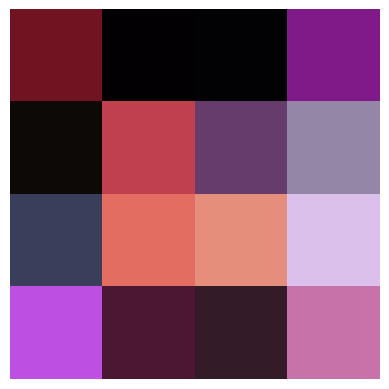

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<08:12,  2.11s/it]

ErrD: -0.24659907817840576, ErrG: 0.2938881516456604


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:23<07:52,  2.11s/it]

ErrD: -0.34518784284591675, ErrG: 0.4071577191352844


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:45<07:34,  2.13s/it]

ErrD: -0.3171134293079376, ErrG: 0.18441241979599


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:06<07:12,  2.12s/it]

ErrD: -0.28329843282699585, ErrG: -0.3658386468887329


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:27<06:49,  2.11s/it]

ErrD: -0.3650553524494171, ErrG: -0.12529805302619934


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [01:48<06:35,  2.15s/it]

ErrD: -0.23218613862991333, ErrG: -0.34419578313827515


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:10<06:09,  2.13s/it]

ErrD: -0.2838415205478668, ErrG: -0.25401321053504944


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [02:31<05:50,  2.14s/it]

ErrD: -0.12769441306591034, ErrG: -0.43108415603637695


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [02:52<05:22,  2.10s/it]

ErrD: -0.313606321811676, ErrG: 0.06944616138935089


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:14<05:06,  2.13s/it]

ErrD: -0.29249051213264465, ErrG: -0.23961767554283142


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [03:38<05:26,  2.43s/it]

ErrD: -0.290637731552124, ErrG: -0.1496354192495346


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:02<05:05,  2.46s/it]

ErrD: -0.22211503982543945, ErrG: -0.31219300627708435


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:26<04:29,  2.36s/it]

ErrD: -0.15062949061393738, ErrG: -0.22185762226581573


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [04:49<04:09,  2.40s/it]

ErrD: -0.2975114583969116, ErrG: -0.028849516063928604


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:11<03:30,  2.24s/it]

ErrD: -0.049636319279670715, ErrG: -0.4072624444961548


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:33<03:07,  2.23s/it]

ErrD: -0.17278961837291718, ErrG: -0.8744111061096191


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [05:56<02:50,  2.31s/it]

ErrD: -0.18706995248794556, ErrG: -0.8079366683959961


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:19<02:28,  2.32s/it]

ErrD: -0.16032220423221588, ErrG: 0.06780131161212921


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [06:42<02:03,  2.28s/it]

ErrD: -0.2909504175186157, ErrG: 0.2979191839694977


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:03<01:34,  2.15s/it]

ErrD: -0.21881034970283508, ErrG: -0.29791879653930664


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:25<01:13,  2.17s/it]

ErrD: -0.14972451329231262, ErrG: -0.2809470295906067


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [07:47<00:51,  2.14s/it]

ErrD: -0.07347501069307327, ErrG: -0.17077063024044037


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:09<00:31,  2.25s/it]

ErrD: -0.6071036458015442, ErrG: -0.5954318642616272


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [08:31<00:08,  2.23s/it]

ErrD: -0.09357696771621704, ErrG: 0.8113663792610168


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [08:39<00:00,  2.21s/it]

ErrD: -0.12224049121141434, ErrG: 0.3484346270561218


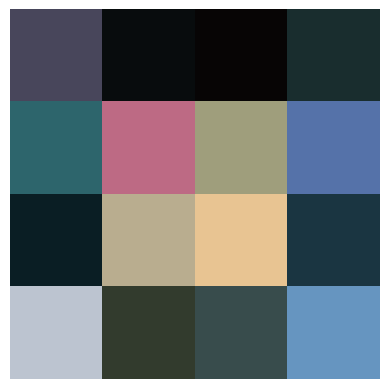

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): MinibatchDiscrimination()
    (6): WSConv2d(
      (conv): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (7): LeakyReLU(negative_slope=0.2)
    (8): WSConv2d(
      (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (9): LeakyReLU(negative_slope=0.2)
    (10): WSConv2d(
      (conv): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (downsample): Upsample(scale_factor=0.5, mode='nearest')
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (leaky): LeakyRe

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:03<11:46,  3.02s/it]

ErrD: 1.5615060329437256, ErrG: -0.25588276982307434


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:27<09:05,  2.44s/it]

ErrD: -1.3301199674606323, ErrG: 1.5969902276992798


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:51<08:44,  2.45s/it]

ErrD: -3.2570409774780273, ErrG: 4.183938026428223


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:15<08:10,  2.40s/it]

ErrD: -4.340734004974365, ErrG: 8.011212348937988


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:39<07:47,  2.41s/it]

ErrD: -3.1881868839263916, ErrG: 3.559448719024658


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:04<07:22,  2.40s/it]

ErrD: -2.8232624530792236, ErrG: 5.91153621673584


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:28<07:07,  2.45s/it]

ErrD: -2.380596399307251, ErrG: 4.050833225250244


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:52<06:43,  2.46s/it]

ErrD: -2.1159472465515137, ErrG: 4.395027160644531


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:16<06:10,  2.41s/it]

ErrD: -2.942854642868042, ErrG: 3.0175678730010986


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:41<05:50,  2.44s/it]

ErrD: -2.099426507949829, ErrG: 1.7328282594680786


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:03<05:03,  2.27s/it]

ErrD: -2.159356117248535, ErrG: 1.8837101459503174


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:26<04:48,  2.33s/it]

ErrD: -1.7644405364990234, ErrG: 0.8759393692016602


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:49<04:16,  2.25s/it]

ErrD: -1.5573408603668213, ErrG: 1.4537138938903809


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:13<04:09,  2.40s/it]

ErrD: -1.7498606443405151, ErrG: 0.42058101296424866


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:36<03:45,  2.40s/it]

ErrD: -1.6747543811798096, ErrG: 0.7797871828079224


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:58<03:08,  2.24s/it]

ErrD: -1.4970422983169556, ErrG: -0.19407936930656433


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:21<02:46,  2.26s/it]

ErrD: -1.466651201248169, ErrG: 2.343750238418579


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:44<02:32,  2.38s/it]

ErrD: -1.1208221912384033, ErrG: 0.0688045546412468


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:08<02:03,  2.30s/it]

ErrD: -1.991094946861267, ErrG: 1.832590103149414


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:30<01:39,  2.25s/it]

ErrD: -0.6046543717384338, ErrG: 0.3966946005821228


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:52<01:17,  2.27s/it]

ErrD: -1.2998520135879517, ErrG: 1.700976848602295


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:14<00:53,  2.21s/it]

ErrD: -1.0388983488082886, ErrG: 2.2276697158813477


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:37<00:32,  2.31s/it]

ErrD: -0.9070225954055786, ErrG: 1.9793424606323242


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [09:00<00:09,  2.27s/it]

ErrD: -1.3200857639312744, ErrG: 1.4509410858154297


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:09<00:00,  2.34s/it]

ErrD: -1.0628389120101929, ErrG: -0.549521267414093


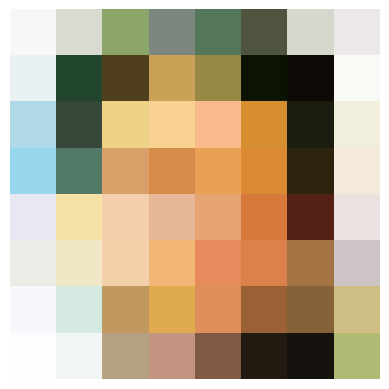

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<09:21,  2.40s/it]

ErrD: -0.5181090235710144, ErrG: -0.08257970958948135


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:26<08:46,  2.35s/it]

ErrD: -0.6366010308265686, ErrG: 1.393571376800537


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:48<08:06,  2.27s/it]

ErrD: -1.651902675628662, ErrG: 2.2088279724121094


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:11<07:32,  2.22s/it]

ErrD: -0.06993919610977173, ErrG: 0.46297264099121094


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:33<07:40,  2.38s/it]

ErrD: -0.8530896306037903, ErrG: 0.008788071572780609


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [01:56<06:50,  2.23s/it]

ErrD: -0.8374772071838379, ErrG: 0.4341695308685303


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:19<06:49,  2.35s/it]

ErrD: -0.613976240158081, ErrG: -0.3667696714401245


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [02:42<06:11,  2.27s/it]

ErrD: -0.8636168241500854, ErrG: 1.1611312627792358


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:04<05:50,  2.28s/it]

ErrD: -0.4048912525177002, ErrG: 0.6091845035552979


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:27<05:30,  2.29s/it]

ErrD: -0.687757134437561, ErrG: -0.5789570808410645


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [03:50<04:59,  2.23s/it]

ErrD: -0.8807112574577332, ErrG: 0.7928024530410767


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:13<04:51,  2.35s/it]

ErrD: -0.47918248176574707, ErrG: -0.19306731224060059


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:35<04:15,  2.24s/it]

ErrD: -0.44037455320358276, ErrG: -0.31863147020339966


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [04:58<03:53,  2.24s/it]

ErrD: -0.6533609628677368, ErrG: 0.21700353920459747


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:21<03:38,  2.33s/it]

ErrD: -0.345769464969635, ErrG: 1.195565104484558


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:44<03:18,  2.36s/it]

ErrD: -0.30090782046318054, ErrG: -1.4078078269958496


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:06<02:44,  2.23s/it]

ErrD: -0.5101134181022644, ErrG: -1.1636961698532104


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:29<02:28,  2.33s/it]

ErrD: -0.6433231234550476, ErrG: 0.9507147073745728


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [06:53<02:03,  2.28s/it]

ErrD: -0.7127776741981506, ErrG: 0.10152282565832138


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:15<01:42,  2.33s/it]

ErrD: -0.6334651112556458, ErrG: 0.3917391002178192


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:38<01:18,  2.30s/it]

ErrD: -0.4886125326156616, ErrG: 0.3718239665031433


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:01<00:53,  2.23s/it]

ErrD: -0.573049783706665, ErrG: 0.7266857624053955


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:24<00:31,  2.27s/it]

ErrD: -0.9411944150924683, ErrG: 0.5792071223258972


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [08:46<00:09,  2.28s/it]

ErrD: -0.4944976568222046, ErrG: 1.9790626764297485


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [08:54<00:00,  2.27s/it]

ErrD: -0.34580662846565247, ErrG: 0.4794985055923462


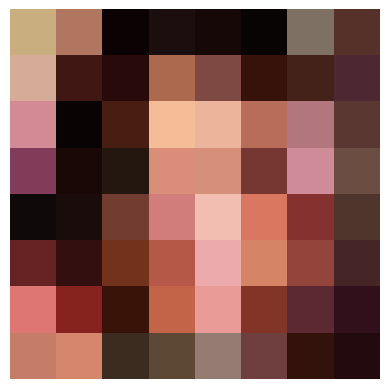

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<08:49,  2.26s/it]

ErrD: -0.08638954907655716, ErrG: 0.0793931856751442


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:25<08:50,  2.37s/it]

ErrD: -0.4750556945800781, ErrG: 2.3824455738067627


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:48<08:17,  2.32s/it]

ErrD: -0.7281899452209473, ErrG: 1.2289131879806519


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:11<07:38,  2.25s/it]

ErrD: -0.6816376447677612, ErrG: 1.2209930419921875


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:33<07:12,  2.23s/it]

ErrD: -0.5173686146736145, ErrG: -0.11460061371326447


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [01:56<06:59,  2.28s/it]

ErrD: -0.559544026851654, ErrG: 0.7180832028388977


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:19<06:29,  2.24s/it]

ErrD: -0.64361172914505, ErrG: 0.8883878588676453


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:42<06:16,  2.30s/it]

ErrD: -0.5819669365882874, ErrG: 2.3550992012023926


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:05<05:57,  2.32s/it]

ErrD: -0.4064770042896271, ErrG: 0.2242688536643982


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:28<05:17,  2.20s/it]

ErrD: -0.2950827181339264, ErrG: 0.5838471055030823


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [03:51<05:16,  2.36s/it]

ErrD: -0.3592205047607422, ErrG: -0.9041483402252197


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:14<04:42,  2.28s/it]

ErrD: -0.5971325039863586, ErrG: 0.36625248193740845


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:37<04:24,  2.32s/it]

ErrD: -0.463056743144989, ErrG: 1.5063393115997314


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:00<03:54,  2.26s/it]

ErrD: -0.4361459016799927, ErrG: 2.21335506439209


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:23<03:33,  2.28s/it]

ErrD: -0.5180462598800659, ErrG: 0.7596899271011353


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:45<03:03,  2.18s/it]

ErrD: -0.5919141173362732, ErrG: -0.24650700390338898


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:07<02:50,  2.30s/it]

ErrD: -0.34187325835227966, ErrG: -0.037616848945617676


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:30<02:25,  2.27s/it]

ErrD: -0.27636393904685974, ErrG: 0.1763528436422348


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [06:53<02:02,  2.26s/it]

ErrD: -0.3604333698749542, ErrG: 0.8322570323944092


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:16<01:36,  2.20s/it]

ErrD: -0.6609406471252441, ErrG: 0.5195294618606567


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:38<01:15,  2.22s/it]

ErrD: -0.5638806819915771, ErrG: 0.952877938747406


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:01<00:53,  2.24s/it]

ErrD: -0.5477455258369446, ErrG: -0.16832391917705536


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:23<00:31,  2.22s/it]

ErrD: -1.0609776973724365, ErrG: 0.0015856698155403137


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [08:46<00:09,  2.29s/it]

ErrD: -0.5048670172691345, ErrG: 0.17345371842384338


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [08:53<00:00,  2.27s/it]

ErrD: -0.386284202337265, ErrG: 1.0116952657699585


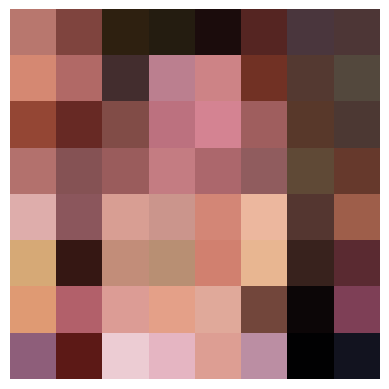

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<09:44,  2.50s/it]

ErrD: -0.30297577381134033, ErrG: -0.3733585476875305


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:25<08:26,  2.26s/it]

ErrD: -0.37506091594696045, ErrG: 2.13521146774292


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:48<08:25,  2.36s/it]

ErrD: -0.4975767731666565, ErrG: -0.13502997159957886


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:10<07:31,  2.21s/it]

ErrD: -0.46823567152023315, ErrG: 0.9830385446548462


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:33<07:12,  2.23s/it]

ErrD: -0.5199090242385864, ErrG: 1.7072337865829468


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [01:55<06:48,  2.22s/it]

ErrD: -0.48400062322616577, ErrG: 0.2989988327026367


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:18<06:23,  2.20s/it]

ErrD: -0.3875639736652374, ErrG: 1.4669008255004883


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [02:41<06:11,  2.26s/it]

ErrD: -0.3977212607860565, ErrG: 0.5843474864959717


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:04<05:53,  2.30s/it]

ErrD: -0.337277889251709, ErrG: 0.922478973865509


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:27<05:30,  2.30s/it]

ErrD: -0.005050893872976303, ErrG: 1.7478954792022705


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [03:50<05:02,  2.26s/it]

ErrD: -0.18759089708328247, ErrG: 0.20423996448516846


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:13<04:48,  2.33s/it]

ErrD: -0.21935714781284332, ErrG: 0.8482279181480408


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:37<04:30,  2.37s/it]

ErrD: -0.10478220134973526, ErrG: 0.4557109773159027


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:01<04:22,  2.52s/it]

ErrD: -0.3001314401626587, ErrG: 1.930388331413269


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:25<03:43,  2.38s/it]

ErrD: -0.2543233036994934, ErrG: 0.5628345608711243


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:49<03:16,  2.34s/it]

ErrD: -0.4664984941482544, ErrG: 0.6992681622505188


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:13<03:00,  2.44s/it]

ErrD: -0.2327623814344406, ErrG: 0.4137166440486908


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:36<02:32,  2.38s/it]

ErrD: -0.22821979224681854, ErrG: 0.8659294843673706


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:00<02:10,  2.42s/it]

ErrD: -0.3682651221752167, ErrG: 0.9290217161178589


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:23<01:47,  2.44s/it]

ErrD: -0.3068246841430664, ErrG: 0.19744950532913208


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:47<01:20,  2.35s/it]

ErrD: -0.42467328906059265, ErrG: 1.929821252822876


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:11<00:58,  2.44s/it]

ErrD: -0.19217462837696075, ErrG: 1.869217872619629


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:36<00:34,  2.49s/it]

ErrD: -0.7575079798698425, ErrG: -0.5480964183807373


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [09:00<00:09,  2.40s/it]

ErrD: -0.573773980140686, ErrG: 1.1606844663619995


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:09<00:00,  2.34s/it]

ErrD: -0.1566196084022522, ErrG: -0.9986429214477539


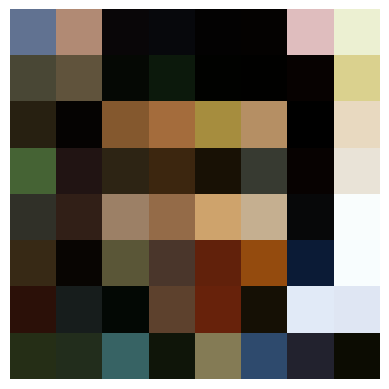

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): LeakyReLU(negative_slope=0.2)
    (7): WSConv2d(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (8): LeakyReLU(negative_slope=0.2)
    (9): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (10): MinibatchDiscrimination()
    (11): WSConv2d(
      (conv): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (12): LeakyReLU(ne

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:03<12:05,  3.10s/it]

ErrD: 1.4294434785842896, ErrG: -1.2690280675888062


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:27<09:07,  2.45s/it]

ErrD: -11.041569709777832, ErrG: 1.4678415060043335


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:51<08:32,  2.39s/it]

ErrD: -9.738691329956055, ErrG: -0.4717923402786255


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:16<08:24,  2.48s/it]

ErrD: -9.692051887512207, ErrG: 4.077191352844238


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:41<08:00,  2.48s/it]

ErrD: -6.173394203186035, ErrG: -1.0675902366638184


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:06<07:34,  2.47s/it]

ErrD: -6.445277214050293, ErrG: 3.6505508422851562


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:30<07:08,  2.46s/it]

ErrD: -9.595072746276855, ErrG: -1.1162047386169434


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:55<06:34,  2.41s/it]

ErrD: -8.61972713470459, ErrG: -0.3602036237716675


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:34<12:11,  4.75s/it]

ErrD: -13.257962226867676, ErrG: 13.695996284484863


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:57<05:49,  2.42s/it]

ErrD: -7.686223030090332, ErrG: -1.1536808013916016


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:20<05:12,  2.33s/it]

ErrD: -7.842306137084961, ErrG: 4.589844703674316


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:44<04:54,  2.38s/it]

ErrD: -7.177781105041504, ErrG: -4.782118797302246


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:14<05:41,  3.00s/it]

ErrD: -6.267911911010742, ErrG: 0.4171801805496216


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:38<03:53,  2.24s/it]

ErrD: -5.560876369476318, ErrG: 6.538841724395752


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:44<12:42,  8.11s/it]

ErrD: -6.611481189727783, ErrG: 4.062997817993164


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [07:45<06:38,  4.75s/it]

ErrD: -4.171739101409912, ErrG: 6.538713455200195


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [09:06<12:40, 10.27s/it]

ErrD: -5.963068962097168, ErrG: -9.056982040405273


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [10:01<03:21,  3.15s/it]

ErrD: -5.168331146240234, ErrG: -1.1741750240325928


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [10:25<02:13,  2.48s/it]

ErrD: -4.740208148956299, ErrG: 2.626840114593506


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [10:50<01:47,  2.44s/it]

ErrD: -4.7245612144470215, ErrG: -0.14616967737674713


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [11:14<01:21,  2.38s/it]

ErrD: -3.9569294452667236, ErrG: 17.074146270751953


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [11:40<01:03,  2.64s/it]

ErrD: -3.5559029579162598, ErrG: -2.3524160385131836


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [12:07<00:38,  2.74s/it]

ErrD: -3.9468677043914795, ErrG: -1.6350712776184082


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [12:35<00:10,  2.63s/it]

ErrD: -3.5880024433135986, ErrG: -5.390665054321289


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [12:45<00:00,  3.26s/it]

ErrD: -3.73114013671875, ErrG: 7.975285530090332


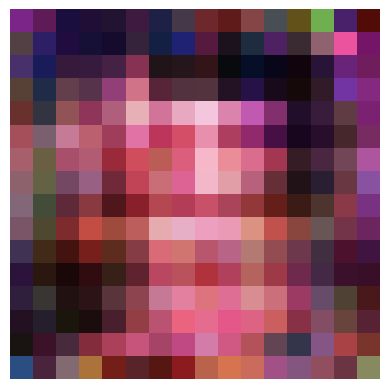

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:58,  2.81s/it]

ErrD: -3.6271002292633057, ErrG: -0.27982962131500244


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:30<10:09,  2.72s/it]

ErrD: -3.051938533782959, ErrG: 11.839825630187988


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:57<09:54,  2.78s/it]

ErrD: -3.480743646621704, ErrG: 2.2803592681884766


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:25<09:38,  2.84s/it]

ErrD: -3.4636874198913574, ErrG: 9.978551864624023


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:58<10:21,  3.20s/it]

ErrD: -2.939300537109375, ErrG: -1.9116663932800293


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:30<10:21,  3.38s/it]

ErrD: -3.047536611557007, ErrG: 4.98680305480957


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:59<08:19,  2.87s/it]

ErrD: -2.2276363372802734, ErrG: -10.779367446899414


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:26<07:31,  2.75s/it]

ErrD: -2.2141196727752686, ErrG: 1.3200098276138306


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:53<06:54,  2.69s/it]

ErrD: -2.4146792888641357, ErrG: 1.2765934467315674


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [04:19<06:23,  2.66s/it]

ErrD: -2.1797358989715576, ErrG: 2.542823314666748


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:45<05:51,  2.62s/it]

ErrD: -2.0435264110565186, ErrG: -0.2907909154891968


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [05:11<05:24,  2.61s/it]

ErrD: -2.288228988647461, ErrG: 0.190859854221344


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:38<04:57,  2.61s/it]

ErrD: -1.985270619392395, ErrG: -0.0325995534658432


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [06:03<04:21,  2.52s/it]

ErrD: -2.023365020751953, ErrG: 0.06260194629430771


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:28<03:59,  2.54s/it]

ErrD: -1.7756413221359253, ErrG: 3.2838079929351807


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:53<03:29,  2.50s/it]

ErrD: -1.929481863975525, ErrG: 3.166193962097168


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:18<03:04,  2.49s/it]

ErrD: -1.5696525573730469, ErrG: 3.2858567237854004


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:43<02:37,  2.47s/it]

ErrD: -1.8778080940246582, ErrG: 3.9772160053253174


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:07<02:13,  2.47s/it]

ErrD: -1.756892442703247, ErrG: 5.4602885246276855


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:32<01:48,  2.46s/it]

ErrD: -1.7771867513656616, ErrG: -1.791050672531128


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:57<01:23,  2.47s/it]

ErrD: -1.4718888998031616, ErrG: 9.358019828796387


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:21<00:59,  2.46s/it]

ErrD: -1.4239494800567627, ErrG: 2.858713150024414


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:46<00:34,  2.49s/it]

ErrD: -2.3273980617523193, ErrG: -1.395267128944397


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:11<00:10,  2.51s/it]

ErrD: -1.7571529150009155, ErrG: 0.03318899869918823


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:20<00:00,  2.64s/it]

ErrD: -2.03480863571167, ErrG: 9.005212783813477


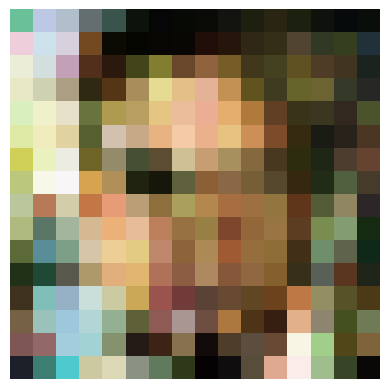

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<10:47,  2.77s/it]

ErrD: -1.7269705533981323, ErrG: -2.2422561645507812


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:27<09:08,  2.45s/it]

ErrD: -2.114165782928467, ErrG: 5.602695941925049


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:53<09:06,  2.55s/it]

ErrD: -1.7900439500808716, ErrG: 1.0248420238494873


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:18<08:25,  2.48s/it]

ErrD: -1.9895715713500977, ErrG: 4.529962539672852


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:43<08:02,  2.49s/it]

ErrD: -1.4639588594436646, ErrG: 4.700066089630127


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:08<07:45,  2.53s/it]

ErrD: -1.6840349435806274, ErrG: -2.9584455490112305


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:33<07:18,  2.52s/it]

ErrD: -1.9180768728256226, ErrG: 1.7573583126068115


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:58<06:54,  2.53s/it]

ErrD: -1.61429762840271, ErrG: 0.5798495411872864


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:24<06:39,  2.59s/it]

ErrD: -1.180821418762207, ErrG: 5.672976493835449


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:49<05:58,  2.49s/it]

ErrD: -1.3324999809265137, ErrG: 1.6114389896392822


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:14<05:35,  2.50s/it]

ErrD: -0.6067444086074829, ErrG: 2.923821449279785


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:41<05:35,  2.71s/it]

ErrD: -1.4545964002609253, ErrG: 0.2608782649040222


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:06<04:35,  2.41s/it]

ErrD: -1.383570671081543, ErrG: -3.717385768890381


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:30<04:15,  2.46s/it]

ErrD: -1.4856349229812622, ErrG: 8.056476593017578


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:56<03:56,  2.52s/it]

ErrD: -1.0116615295410156, ErrG: 5.801783561706543


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:20<03:20,  2.38s/it]

ErrD: -1.3758591413497925, ErrG: -0.7543512582778931


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:44<02:56,  2.39s/it]

ErrD: -1.980316162109375, ErrG: 2.9140994548797607


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:09<02:45,  2.59s/it]

ErrD: -1.322471022605896, ErrG: 3.3817901611328125


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:34<02:13,  2.46s/it]

ErrD: -1.1653324365615845, ErrG: -2.053370952606201


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:58<01:45,  2.40s/it]

ErrD: -1.1308765411376953, ErrG: -3.9139342308044434


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:22<01:20,  2.38s/it]

ErrD: -0.9498770833015442, ErrG: 5.986271858215332


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:46<00:57,  2.38s/it]

ErrD: -0.7841152548789978, ErrG: -1.1610735654830933


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:10<00:33,  2.40s/it]

ErrD: -1.7309514284133911, ErrG: -0.1547481268644333


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [09:34<00:09,  2.38s/it]

ErrD: -1.1514688730239868, ErrG: -3.8240151405334473


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:42<00:00,  2.48s/it]

ErrD: -0.8689133524894714, ErrG: -4.879395008087158


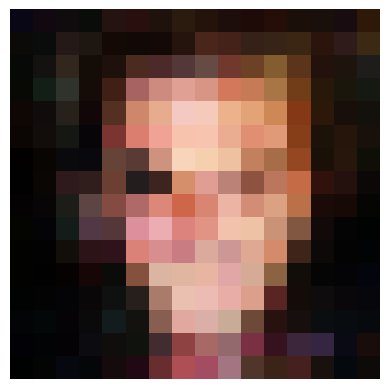

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<09:47,  2.51s/it]

ErrD: -0.48463672399520874, ErrG: 5.943967819213867


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:27<09:41,  2.60s/it]

ErrD: -0.6978731155395508, ErrG: 5.982054710388184


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:52<08:37,  2.42s/it]

ErrD: -1.1545435190200806, ErrG: 0.2194259911775589


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:16<08:11,  2.41s/it]

ErrD: -1.1931644678115845, ErrG: 3.9555747509002686


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:40<07:46,  2.41s/it]

ErrD: -1.3264460563659668, ErrG: -2.5238118171691895


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:07<08:38,  2.82s/it]

ErrD: -1.3074915409088135, ErrG: -2.969697952270508


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:37<09:00,  3.10s/it]

ErrD: -1.1330114603042603, ErrG: 3.6617369651794434


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:02<06:53,  2.52s/it]

ErrD: -1.0110890865325928, ErrG: 0.7047346830368042


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:26<05:56,  2.32s/it]

ErrD: -0.9589337706565857, ErrG: -0.02471352368593216


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:48<05:18,  2.21s/it]

ErrD: -0.7578551173210144, ErrG: 4.278090476989746


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:13<05:45,  2.58s/it]

ErrD: -0.3312737047672272, ErrG: 2.618826389312744


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:39<05:28,  2.65s/it]

ErrD: -0.9746090769767761, ErrG: -0.8625670671463013


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:04<04:54,  2.59s/it]

ErrD: -0.6760160326957703, ErrG: -0.5400788187980652


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:29<04:17,  2.48s/it]

ErrD: -0.8737105131149292, ErrG: 2.870948553085327


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:54<03:48,  2.43s/it]

ErrD: -0.9307281970977783, ErrG: -3.023081064224243


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:18<03:28,  2.48s/it]

ErrD: -1.1619597673416138, ErrG: 0.15202684700489044


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:45<03:30,  2.84s/it]

ErrD: -1.015840768814087, ErrG: 2.182696580886841


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:13<03:00,  2.82s/it]

ErrD: -0.5572401285171509, ErrG: 1.3230681419372559


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:43<02:41,  2.99s/it]

ErrD: -1.2166322469711304, ErrG: 0.1484559029340744


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:13<02:10,  2.96s/it]

ErrD: -1.251948595046997, ErrG: -1.7989225387573242


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:42<01:39,  2.94s/it]

ErrD: -0.9212289452552795, ErrG: 3.9278626441955566


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:10<01:03,  2.65s/it]

ErrD: -1.1553677320480347, ErrG: 0.9171720147132874


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:46<00:35,  2.56s/it]

ErrD: -1.7036253213882446, ErrG: 6.846050262451172


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:09<00:09,  2.30s/it]

ErrD: -0.8546136021614075, ErrG: -6.568787574768066


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:17<00:00,  2.63s/it]

ErrD: -0.8581636548042297, ErrG: 5.308492660522461


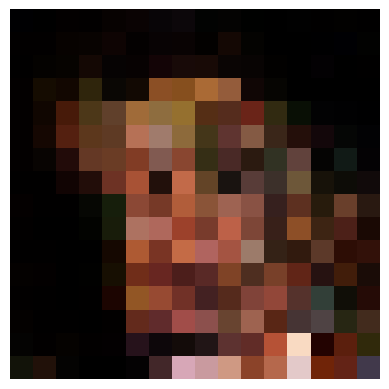

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): WSConv2d(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): LeakyReLU(negative_slope=0.2)
    (7): WSConv2d(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (8): LeakyReLU(negative_slope=0.2)
    (9): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (10): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): WSConv2d(
 

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:04<16:14,  4.17s/it]

ErrD: 3.6581432819366455, ErrG: 7.221684455871582


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:29<09:32,  2.56s/it]

ErrD: -21.4791316986084, ErrG: 3.8883533477783203


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:55<09:01,  2.53s/it]

ErrD: -34.98162841796875, ErrG: 1.721494436264038


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:20<08:35,  2.53s/it]

ErrD: -25.075950622558594, ErrG: 10.245407104492188


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:45<08:09,  2.52s/it]

ErrD: -22.026718139648438, ErrG: 10.384194374084473


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:10<07:45,  2.53s/it]

ErrD: -22.344745635986328, ErrG: 7.539408206939697


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:36<07:16,  2.51s/it]

ErrD: -27.750831604003906, ErrG: 3.160050392150879


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [03:06<09:24,  3.45s/it]

ErrD: -28.23310089111328, ErrG: -3.597368001937866


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:43<08:28,  3.30s/it]

ErrD: -22.12141227722168, ErrG: 105.74705505371094


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [04:13<07:01,  2.93s/it]

ErrD: -26.569568634033203, ErrG: 5.182320594787598


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:41<06:25,  2.87s/it]

ErrD: -21.775644302368164, ErrG: 5.785780906677246


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [05:09<05:40,  2.74s/it]

ErrD: -19.188291549682617, ErrG: 29.384780883789062


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:36<05:28,  2.88s/it]

ErrD: -19.276599884033203, ErrG: -4.280310153961182


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [06:07<05:07,  2.95s/it]

ErrD: -19.909381866455078, ErrG: 8.235668182373047


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:39<04:59,  3.19s/it]

ErrD: -18.78952407836914, ErrG: 6.109010696411133


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [07:10<04:06,  2.94s/it]

ErrD: -22.239990234375, ErrG: -3.41827392578125


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:40<03:50,  3.11s/it]

ErrD: -16.601604461669922, ErrG: -5.992763519287109


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [08:29<07:44,  7.26s/it]

ErrD: -17.927217483520508, ErrG: 3.7890586853027344


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [09:14<04:01,  4.48s/it]

ErrD: -13.837200164794922, ErrG: 25.447227478027344


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [10:04<05:26,  7.42s/it]

ErrD: -14.07452392578125, ErrG: -9.285338401794434


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [12:54<09:33, 16.86s/it]

ErrD: -12.539690971374512, ErrG: -2.735764980316162


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [14:40<04:30, 11.28s/it]

ErrD: -12.12162971496582, ErrG: 6.902530670166016


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [15:06<00:38,  2.72s/it]

ErrD: -12.141627311706543, ErrG: -0.31065160036087036


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [15:30<00:09,  2.45s/it]

ErrD: -11.620125770568848, ErrG: -13.956411361694336


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [15:39<00:00,  4.00s/it]

ErrD: -10.312606811523438, ErrG: -15.881824493408203


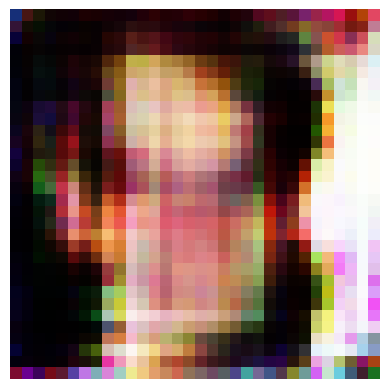

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:06,  2.59s/it]

ErrD: -9.409286499023438, ErrG: 13.473381042480469


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:29<10:09,  2.72s/it]

ErrD: -9.19632339477539, ErrG: 8.528570175170898


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:56<09:34,  2.69s/it]

ErrD: -8.859358787536621, ErrG: -6.252225399017334


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:24<09:25,  2.77s/it]

ErrD: -7.561861515045166, ErrG: -19.029804229736328


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [03:24<25:35,  7.91s/it]

ErrD: -8.028234481811523, ErrG: -8.105958938598633


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [03:52<08:54,  2.90s/it]

ErrD: -13.644554138183594, ErrG: 8.882341384887695


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [04:20<08:15,  2.85s/it]

ErrD: -6.664129257202148, ErrG: -2.077943801879883


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [04:46<07:06,  2.60s/it]

ErrD: -7.716106414794922, ErrG: -11.334878921508789


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [05:12<06:39,  2.59s/it]

ErrD: -7.087947845458984, ErrG: -4.055487632751465


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [05:38<06:14,  2.60s/it]

ErrD: -3.1384639739990234, ErrG: 2.143310070037842


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [06:04<05:48,  2.60s/it]

ErrD: -4.63484525680542, ErrG: -15.786285400390625


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [06:31<05:38,  2.73s/it]

ErrD: -6.701008319854736, ErrG: -0.7129920125007629


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [06:59<05:20,  2.81s/it]

ErrD: -4.241756916046143, ErrG: -6.582221031188965


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [07:30<04:50,  2.79s/it]

ErrD: -4.8762712478637695, ErrG: -4.260276794433594


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [07:58<04:16,  2.73s/it]

ErrD: -4.305296421051025, ErrG: -2.7035670280456543


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [08:25<03:46,  2.70s/it]

ErrD: -1.610888123512268, ErrG: 1.9050800800323486


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [08:52<03:20,  2.71s/it]

ErrD: -3.471022367477417, ErrG: 25.94186782836914


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [09:20<02:48,  2.63s/it]

ErrD: -4.525709629058838, ErrG: -2.532583236694336


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [09:46<02:22,  2.63s/it]

ErrD: -3.3441524505615234, ErrG: 2.319063663482666


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [10:11<01:55,  2.63s/it]

ErrD: -4.443408012390137, ErrG: 4.242343425750732


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [10:41<01:37,  2.88s/it]

ErrD: -4.118582248687744, ErrG: 5.863239288330078


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [11:07<01:03,  2.63s/it]

ErrD: -3.2073898315429688, ErrG: 6.466611385345459


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [11:34<00:37,  2.69s/it]

ErrD: -4.06221342086792, ErrG: 17.309795379638672


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [12:01<00:10,  2.65s/it]

ErrD: -3.294365882873535, ErrG: 4.973060131072998


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [12:10<00:00,  3.11s/it]

ErrD: -3.156201124191284, ErrG: 18.05950355529785


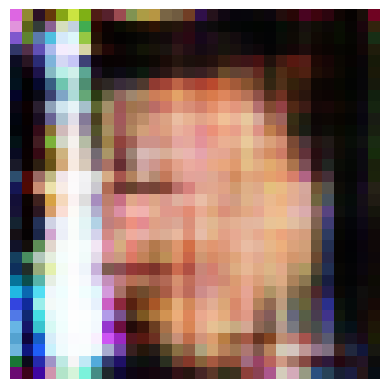

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<10:11,  2.61s/it]

ErrD: -2.8753204345703125, ErrG: -3.8837075233459473


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:28<09:56,  2.66s/it]

ErrD: -3.89401912689209, ErrG: 7.564692497253418


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:56<09:58,  2.80s/it]

ErrD: -4.249111652374268, ErrG: 9.955541610717773


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:25<10:09,  2.99s/it]

ErrD: -3.5196328163146973, ErrG: 0.8238801956176758


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:53<09:02,  2.80s/it]

ErrD: -2.7746126651763916, ErrG: 5.932727813720703


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [03:11<21:51,  7.13s/it]

ErrD: -3.6077489852905273, ErrG: 3.797837734222412


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [03:40<08:29,  2.93s/it]

ErrD: -2.980126142501831, ErrG: 14.2643461227417


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [04:06<07:11,  2.63s/it]

ErrD: -2.608531951904297, ErrG: 23.757009506225586


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [04:32<06:34,  2.56s/it]

ErrD: -3.5449635982513428, ErrG: 10.61854362487793


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [05:02<06:43,  2.80s/it]

ErrD: -3.539543628692627, ErrG: -3.094700336456299


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [05:27<05:46,  2.59s/it]

ErrD: -2.449585437774658, ErrG: 1.5657869577407837


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [05:53<05:17,  2.56s/it]

ErrD: -3.525648593902588, ErrG: -7.0414228439331055


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [06:19<04:52,  2.57s/it]

ErrD: -3.090906858444214, ErrG: -2.1806411743164062


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [06:44<04:24,  2.55s/it]

ErrD: -3.566423177719116, ErrG: 11.212886810302734


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [07:10<04:00,  2.56s/it]

ErrD: -2.7971885204315186, ErrG: -2.5637078285217285


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [07:35<03:32,  2.54s/it]

ErrD: -3.1664206981658936, ErrG: 4.913911819458008


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [08:01<03:08,  2.54s/it]

ErrD: -2.5918779373168945, ErrG: 5.005548477172852


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [08:26<02:42,  2.55s/it]

ErrD: -2.887098550796509, ErrG: -7.528518199920654


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:52<02:17,  2.55s/it]

ErrD: -3.1355063915252686, ErrG: 4.3849382400512695


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [09:17<01:52,  2.55s/it]

ErrD: -2.3018999099731445, ErrG: -8.138036727905273


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:43<01:28,  2.59s/it]

ErrD: -3.124593496322632, ErrG: 3.258289337158203


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [10:10<01:01,  2.55s/it]

ErrD: -2.0491254329681396, ErrG: 15.351223945617676


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [10:38<00:39,  2.86s/it]

ErrD: -3.526317596435547, ErrG: 3.418555736541748


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [11:04<00:10,  2.54s/it]

ErrD: -2.4992122650146484, ErrG: -3.813234329223633


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [11:13<00:00,  2.86s/it]

ErrD: -2.436861991882324, ErrG: 1.1278908252716064


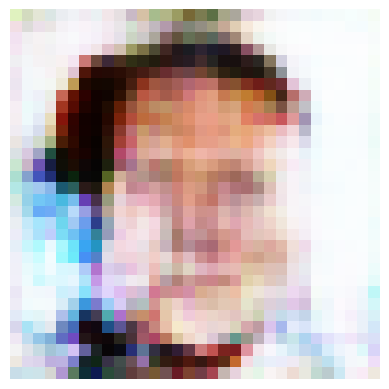

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:04,  2.58s/it]

ErrD: -2.833159923553467, ErrG: 0.2913680672645569


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:28<09:37,  2.58s/it]

ErrD: -2.709916591644287, ErrG: 8.196354866027832


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:53<09:09,  2.57s/it]

ErrD: -2.7952075004577637, ErrG: 1.5361170768737793


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:19<08:44,  2.57s/it]

ErrD: -2.3290460109710693, ErrG: -1.6614575386047363


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:45<08:21,  2.59s/it]

ErrD: -2.4505300521850586, ErrG: 1.2192007303237915


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:11<07:53,  2.58s/it]

ErrD: -2.556457757949829, ErrG: 5.229769706726074


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:36<07:29,  2.58s/it]

ErrD: -1.8437354564666748, ErrG: -4.263388633728027


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:02<07:01,  2.57s/it]

ErrD: -2.06345534324646, ErrG: 11.50506591796875


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:28<06:39,  2.60s/it]

ErrD: -2.2467691898345947, ErrG: -1.6746456623077393


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:54<06:33,  2.73s/it]

ErrD: -2.3308968544006348, ErrG: -2.0429115295410156


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:22<06:14,  2.80s/it]

ErrD: -2.068387746810913, ErrG: -1.1581180095672607


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:50<05:43,  2.77s/it]

ErrD: -1.9875528812408447, ErrG: 4.00813102722168


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:17<05:05,  2.68s/it]

ErrD: -1.5002546310424805, ErrG: -2.6870357990264893


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:53<07:51,  4.53s/it]

ErrD: -2.284043788909912, ErrG: 7.948582649230957


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:36<06:21,  4.05s/it]

ErrD: -2.082152843475342, ErrG: 3.357102632522583


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [07:24<05:05,  3.64s/it]

ErrD: -1.6826688051223755, ErrG: -8.558006286621094


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:49<03:03,  2.48s/it]

ErrD: -2.181863307952881, ErrG: -1.7718510627746582


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [09:14<13:06, 12.28s/it]

ErrD: -2.1624019145965576, ErrG: 0.6615880727767944


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [11:42<13:35, 15.10s/it]

ErrD: -2.360568046569824, ErrG: -4.388261795043945


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [14:30<12:43, 17.36s/it]

ErrD: -1.9484654664993286, ErrG: -0.13811206817626953


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [16:37<04:31,  7.99s/it]

ErrD: -2.6473593711853027, ErrG: 22.351966857910156


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [17:11<01:12,  3.04s/it]

ErrD: -2.0538787841796875, ErrG: 2.2618978023529053


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [17:36<00:35,  2.56s/it]

ErrD: -2.308948516845703, ErrG: 18.53091049194336


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [18:02<00:10,  2.52s/it]

ErrD: -2.0220727920532227, ErrG: 1.8181461095809937


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [18:10<00:00,  4.64s/it]

ErrD: -2.312420606613159, ErrG: -0.3264833986759186


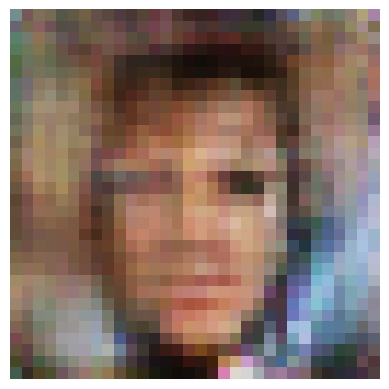

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): WSConv2d(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): LeakyReLU(negative_slope=0.2)
    (7): WSConv2d(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (8): LeakyReLU(negative_slope=0.2)
    (9): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (10): WSConv2d(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): WSConv2d(
     

Epoch 1/2:   0%|▎                                                                    | 1/235 [00:27<1:45:43, 27.11s/it]

ErrD: -1.7739919424057007, ErrG: -4.48101806640625


Epoch 1/2:   5%|███▎                                                                  | 11/235 [01:20<18:14,  4.89s/it]

ErrD: -135.3776397705078, ErrG: -71.26589965820312


Epoch 1/2:   9%|██████▎                                                               | 21/235 [01:55<13:37,  3.82s/it]

ErrD: -211.9341278076172, ErrG: -82.21306610107422


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [02:36<14:37,  4.30s/it]

ErrD: -221.34437561035156, ErrG: 71.31705474853516


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [05:13<46:47, 14.47s/it]

ErrD: -206.33193969726562, ErrG: -19.91359519958496


Epoch 1/2:  22%|██████████████▊                                                     | 51/235 [08:59<1:08:50, 22.45s/it]

ErrD: -146.4005584716797, ErrG: 91.55181121826172


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [10:10<18:58,  6.54s/it]

ErrD: -166.32667541503906, ErrG: 5.253938674926758


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [10:41<08:22,  3.06s/it]

ErrD: -197.76437377929688, ErrG: -54.1756591796875


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [11:12<07:50,  3.05s/it]

ErrD: -180.09890747070312, ErrG: -40.86228561401367


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [11:41<06:51,  2.86s/it]

ErrD: -33.2437629699707, ErrG: 20.965679168701172


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [12:10<06:22,  2.85s/it]

ErrD: -92.42459869384766, ErrG: 17.20397186279297


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [13:05<07:45,  3.75s/it]

ErrD: -51.87699890136719, ErrG: 98.99633026123047


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [13:33<05:25,  2.85s/it]

ErrD: -64.07402038574219, ErrG: 3.3177080154418945


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [14:00<04:45,  2.75s/it]

ErrD: -41.260704040527344, ErrG: 36.154762268066406


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [14:28<04:18,  2.75s/it]

ErrD: -37.46513366699219, ErrG: 32.1518440246582


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [14:55<03:44,  2.68s/it]

ErrD: -37.47081756591797, ErrG: -0.19195640087127686


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [15:21<03:15,  2.64s/it]

ErrD: -31.17287254333496, ErrG: -49.67816925048828


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [15:48<02:50,  2.66s/it]

ErrD: -43.76429748535156, ErrG: 27.09522247314453


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [16:15<02:30,  2.79s/it]

ErrD: -46.606285095214844, ErrG: 62.40911102294922


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [16:43<02:02,  2.78s/it]

ErrD: -37.66245651245117, ErrG: 66.37007904052734


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [17:09<01:30,  2.65s/it]

ErrD: -36.42366409301758, ErrG: 10.888166427612305


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [17:36<01:02,  2.60s/it]

ErrD: -31.14272689819336, ErrG: 8.209285736083984


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [18:02<00:37,  2.69s/it]

ErrD: -26.447725296020508, ErrG: 16.17578887939453


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [18:28<00:10,  2.65s/it]

ErrD: -25.967185974121094, ErrG: 74.52883911132812


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [18:38<00:00,  4.76s/it]

ErrD: -17.390850067138672, ErrG: 71.70537567138672


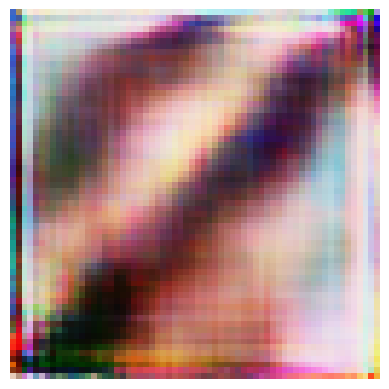

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:02,  2.57s/it]

ErrD: -14.719149589538574, ErrG: -7.751009464263916


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:29<10:11,  2.73s/it]

ErrD: -19.10778045654297, ErrG: 18.099971771240234


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:55<09:31,  2.67s/it]

ErrD: -16.72446060180664, ErrG: 6.553102016448975


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:21<08:52,  2.61s/it]

ErrD: -20.91208267211914, ErrG: 24.173547744750977


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:49<08:36,  2.66s/it]

ErrD: -19.166414260864258, ErrG: 49.76634979248047


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:16<08:15,  2.69s/it]

ErrD: -14.668726921081543, ErrG: 29.15595054626465


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:43<07:53,  2.72s/it]

ErrD: -15.587589263916016, ErrG: 38.71147155761719


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:10<07:13,  2.64s/it]

ErrD: -9.122035026550293, ErrG: 25.821422576904297


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:36<07:03,  2.75s/it]

ErrD: -8.485523223876953, ErrG: 24.11252212524414


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [04:03<06:16,  2.61s/it]

ErrD: -3.8335182666778564, ErrG: -1.675241470336914


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:30<05:59,  2.68s/it]

ErrD: -5.685854434967041, ErrG: 2.766928195953369


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:57<05:38,  2.73s/it]

ErrD: -7.0605149269104, ErrG: 8.969158172607422


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:23<04:55,  2.59s/it]

ErrD: -7.398234844207764, ErrG: 17.106529235839844


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:50<04:35,  2.65s/it]

ErrD: -6.323101043701172, ErrG: 37.78080368041992


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:17<04:13,  2.70s/it]

ErrD: -3.729738235473633, ErrG: -2.6846561431884766


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:44<03:48,  2.73s/it]

ErrD: -3.075460910797119, ErrG: -16.17066192626953


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:10<03:09,  2.56s/it]

ErrD: -3.766184091567993, ErrG: 4.984004020690918


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:36<02:56,  2.75s/it]

ErrD: -6.276556015014648, ErrG: 15.431473731994629


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:04<02:23,  2.66s/it]

ErrD: -2.840885639190674, ErrG: 5.354907989501953


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:30<01:55,  2.64s/it]

ErrD: -3.5330963134765625, ErrG: -4.492537021636963


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:58<01:35,  2.80s/it]

ErrD: -4.832043170928955, ErrG: 2.897291660308838


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:24<01:02,  2.62s/it]

ErrD: -4.142062664031982, ErrG: 1.7659497261047363


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:50<00:37,  2.67s/it]

ErrD: -3.5390424728393555, ErrG: 27.24995231628418


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:18<00:11,  2.77s/it]

ErrD: -2.9227516651153564, ErrG: -2.5998587608337402


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:27<00:00,  2.67s/it]

ErrD: -2.7637441158294678, ErrG: -12.689247131347656


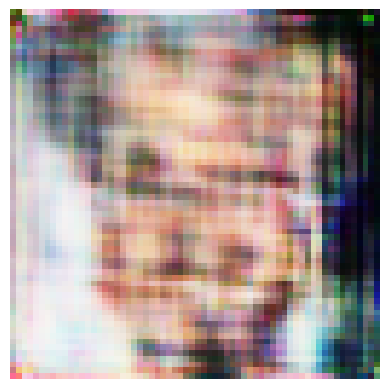

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<10:02,  2.57s/it]

ErrD: -2.1960716247558594, ErrG: 17.46710777282715


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:30<10:18,  2.76s/it]

ErrD: -3.4268860816955566, ErrG: 23.581417083740234


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:57<09:26,  2.65s/it]

ErrD: -4.477369785308838, ErrG: -5.278070449829102


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:24<09:07,  2.69s/it]

ErrD: -3.5062313079833984, ErrG: 6.608323574066162


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:51<09:02,  2.80s/it]

ErrD: -3.4006237983703613, ErrG: 0.5354313850402832


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:18<08:29,  2.77s/it]

ErrD: -3.746659517288208, ErrG: 4.251279830932617


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:45<07:51,  2.71s/it]

ErrD: -2.1224989891052246, ErrG: -12.643906593322754


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [03:12<07:17,  2.67s/it]

ErrD: -3.8333210945129395, ErrG: 11.29388427734375


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:39<07:00,  2.73s/it]

ErrD: -3.3896992206573486, ErrG: 20.263442993164062


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [04:06<06:20,  2.64s/it]

ErrD: -4.057908058166504, ErrG: -0.5794668197631836


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:32<06:06,  2.73s/it]

ErrD: -2.9625401496887207, ErrG: -14.232234001159668


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:59<05:28,  2.65s/it]

ErrD: -3.554348945617676, ErrG: 4.107026100158691


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:26<05:10,  2.72s/it]

ErrD: -3.877112627029419, ErrG: -1.5251480340957642


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:53<04:48,  2.78s/it]

ErrD: -4.136607646942139, ErrG: 18.017234802246094


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:21<04:20,  2.77s/it]

ErrD: -0.7681970596313477, ErrG: 6.689205169677734


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:49<03:55,  2.80s/it]

ErrD: -3.7880003452301025, ErrG: 13.237192153930664


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:16<03:26,  2.79s/it]

ErrD: -3.3498244285583496, ErrG: 8.425962448120117


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:43<02:51,  2.68s/it]

ErrD: -3.745939254760742, ErrG: 1.9883434772491455


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:10<02:22,  2.64s/it]

ErrD: -3.3198800086975098, ErrG: -4.14584493637085


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:37<01:57,  2.67s/it]

ErrD: -2.5297458171844482, ErrG: 9.635616302490234


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:04<01:34,  2.78s/it]

ErrD: -4.0570783615112305, ErrG: 18.085254669189453


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:31<01:05,  2.72s/it]

ErrD: -2.4152936935424805, ErrG: 10.540077209472656


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:58<00:36,  2.64s/it]

ErrD: -4.542529106140137, ErrG: 13.837053298950195


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:26<00:11,  2.76s/it]

ErrD: -3.4453344345092773, ErrG: -1.8068119287490845


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:35<00:00,  2.70s/it]

ErrD: -2.0725581645965576, ErrG: -13.506219863891602


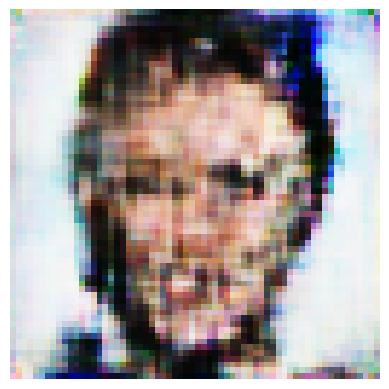

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:52,  2.79s/it]

ErrD: -2.3076581954956055, ErrG: 31.046428680419922


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:30<10:09,  2.72s/it]

ErrD: -3.00620174407959, ErrG: 12.858853340148926


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:56<09:40,  2.71s/it]

ErrD: -3.5487334728240967, ErrG: 9.160018920898438


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:22<08:50,  2.60s/it]

ErrD: -3.103634834289551, ErrG: -7.13813591003418


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:49<08:32,  2.64s/it]

ErrD: -2.744231939315796, ErrG: -9.53091049194336


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:15<08:17,  2.70s/it]

ErrD: -3.214388847351074, ErrG: -8.555809020996094


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:42<07:33,  2.61s/it]

ErrD: -2.897812843322754, ErrG: -7.509346008300781


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:08<07:24,  2.71s/it]

ErrD: -2.5579380989074707, ErrG: 7.489609718322754


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:34<06:35,  2.57s/it]

ErrD: -1.8466854095458984, ErrG: 22.47030258178711


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [04:01<06:24,  2.67s/it]

ErrD: -3.2505362033843994, ErrG: 14.255512237548828


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:28<06:05,  2.73s/it]

ErrD: -1.2717570066452026, ErrG: 5.565669059753418


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:56<05:33,  2.69s/it]

ErrD: -2.8868045806884766, ErrG: -10.35455322265625


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:23<05:07,  2.70s/it]

ErrD: -2.3748764991760254, ErrG: -0.35812318325042725


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:51<04:43,  2.73s/it]

ErrD: -1.192402720451355, ErrG: 3.5754189491271973


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:17<04:11,  2.67s/it]

ErrD: -0.7330574989318848, ErrG: 20.637914657592773


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:45<03:51,  2.76s/it]

ErrD: -2.7771310806274414, ErrG: 0.5971020460128784


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:13<03:22,  2.73s/it]

ErrD: -2.7322685718536377, ErrG: -3.85866117477417


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:39<02:52,  2.69s/it]

ErrD: -2.8443186283111572, ErrG: 13.241903305053711


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:07<02:25,  2.70s/it]

ErrD: -3.1309638023376465, ErrG: 4.685696601867676


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:33<01:58,  2.68s/it]

ErrD: -1.6835203170776367, ErrG: -24.816791534423828


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:01<01:38,  2.91s/it]

ErrD: -2.85738468170166, ErrG: -9.226325035095215


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:28<01:02,  2.62s/it]

ErrD: -3.4041523933410645, ErrG: -11.409279823303223


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:54<00:36,  2.60s/it]

ErrD: -2.618471622467041, ErrG: -2.9701273441314697


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:21<00:10,  2.67s/it]

ErrD: -2.1685922145843506, ErrG: 9.568934440612793


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:30<00:00,  2.68s/it]

ErrD: -2.982139825820923, ErrG: 3.9790332317352295


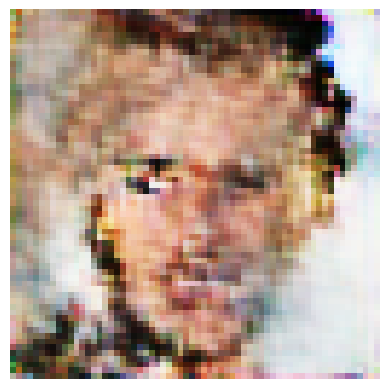

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): WSConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): LeakyReLU(negative_slope=0.2)
    (7): WSConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (8): LeakyReLU(negative_slope=0.2)
    (9): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (10): WSConv2d(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): WSConv2d(
      (c

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:08<34:21,  8.81s/it]

ErrD: -14.318902969360352, ErrG: 22.90164566040039


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:35<10:09,  2.72s/it]

ErrD: -592.739990234375, ErrG: 52.71625518798828


Epoch 1/2:   9%|██████▎                                                               | 21/235 [01:01<09:15,  2.59s/it]

ErrD: -686.939697265625, ErrG: 10.890741348266602


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:28<08:53,  2.61s/it]

ErrD: -570.1177368164062, ErrG: 74.52167510986328


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:54<08:31,  2.64s/it]

ErrD: -736.7117309570312, ErrG: 117.63258361816406


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:20<08:01,  2.62s/it]

ErrD: -512.5723266601562, ErrG: 289.2991943359375


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:46<07:31,  2.59s/it]

ErrD: -708.7586669921875, ErrG: 628.959716796875


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [03:12<07:08,  2.61s/it]

ErrD: -657.1097412109375, ErrG: 239.95999145507812


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:39<06:46,  2.64s/it]

ErrD: -631.7114868164062, ErrG: 330.81121826171875


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [04:05<06:23,  2.67s/it]

ErrD: -464.03424072265625, ErrG: -330.13055419921875


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:31<05:49,  2.61s/it]

ErrD: -520.5149536132812, ErrG: -221.89852905273438


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:57<05:19,  2.58s/it]

ErrD: -617.985595703125, ErrG: 3.429507255554199


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:23<04:54,  2.59s/it]

ErrD: -568.3707885742188, ErrG: -39.28131866455078


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:48<04:24,  2.54s/it]

ErrD: -150.25921630859375, ErrG: 267.99090576171875


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:14<04:03,  2.59s/it]

ErrD: -229.99795532226562, ErrG: 192.90313720703125


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:39<03:33,  2.54s/it]

ErrD: -96.3853530883789, ErrG: 162.97816467285156


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:05<03:12,  2.59s/it]

ErrD: -55.29670715332031, ErrG: 93.22970581054688


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:31<02:41,  2.53s/it]

ErrD: -41.689422607421875, ErrG: 98.98138427734375


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:56<02:15,  2.51s/it]

ErrD: -32.15961456298828, ErrG: 82.61466979980469


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:21<01:52,  2.56s/it]

ErrD: -61.418209075927734, ErrG: 111.5726547241211


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:47<01:25,  2.50s/it]

ErrD: -44.39754104614258, ErrG: 75.94353485107422


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:12<01:01,  2.54s/it]

ErrD: -65.50592803955078, ErrG: 70.57223510742188


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:37<00:35,  2.52s/it]

ErrD: -64.9382553100586, ErrG: 54.776466369628906


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:02<00:09,  2.49s/it]

ErrD: -66.41276550292969, ErrG: 129.48167419433594


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:13<00:00,  2.61s/it]

ErrD: -65.83543395996094, ErrG: 110.17520141601562


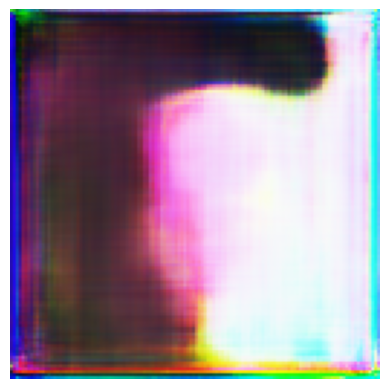

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:55,  2.80s/it]

ErrD: -63.63828659057617, ErrG: -48.4755859375


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:28<09:31,  2.55s/it]

ErrD: -66.10358428955078, ErrG: -32.05923843383789


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:53<08:46,  2.46s/it]

ErrD: -99.6797866821289, ErrG: -16.631057739257812


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:18<08:34,  2.52s/it]

ErrD: -80.9183120727539, ErrG: 1.3003666400909424


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:43<08:11,  2.53s/it]

ErrD: -103.90403747558594, ErrG: 1.5795879364013672


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:08<07:49,  2.55s/it]

ErrD: -74.14425659179688, ErrG: -69.78270721435547


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:34<07:34,  2.61s/it]

ErrD: -73.51702117919922, ErrG: 54.82109832763672


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:00<06:55,  2.53s/it]

ErrD: -96.86653900146484, ErrG: 46.62399673461914


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:25<06:31,  2.55s/it]

ErrD: -54.731258392333984, ErrG: 23.229862213134766


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:50<06:02,  2.52s/it]

ErrD: -74.50411987304688, ErrG: 68.26761627197266


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:15<05:33,  2.49s/it]

ErrD: -33.81648254394531, ErrG: 140.36936950683594


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:41<05:17,  2.56s/it]

ErrD: -51.16604232788086, ErrG: 111.53950500488281


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:06<04:47,  2.53s/it]

ErrD: -46.72826385498047, ErrG: 114.46043395996094


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:31<04:31,  2.61s/it]

ErrD: -29.654836654663086, ErrG: 129.6081085205078


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:57<03:53,  2.48s/it]

ErrD: -29.630695343017578, ErrG: 101.66485595703125


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:21<03:22,  2.41s/it]

ErrD: -36.030548095703125, ErrG: 23.72653579711914


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:44<02:54,  2.35s/it]

ErrD: -30.686525344848633, ErrG: 20.767866134643555


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:07<02:28,  2.32s/it]

ErrD: -22.391597747802734, ErrG: 30.569984436035156


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:31<02:07,  2.36s/it]

ErrD: -15.59056568145752, ErrG: 54.95357131958008


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:55<01:44,  2.38s/it]

ErrD: -8.531177520751953, ErrG: 60.41278839111328


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [08:18<01:20,  2.36s/it]

ErrD: -8.169065475463867, ErrG: 33.460540771484375


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:43<00:58,  2.45s/it]

ErrD: -8.032319068908691, ErrG: 17.903640747070312


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:07<00:33,  2.41s/it]

ErrD: -0.027444958686828613, ErrG: -37.13275146484375


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [09:31<00:09,  2.40s/it]

ErrD: -6.471380233764648, ErrG: 10.594308853149414


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:39<00:00,  2.47s/it]

ErrD: -4.5722198486328125, ErrG: -12.741348266601562


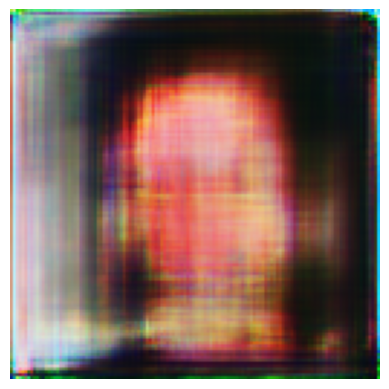

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<09:42,  2.49s/it]

ErrD: -2.2009365558624268, ErrG: 39.41207504272461


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:26<08:56,  2.40s/it]

ErrD: -4.3979644775390625, ErrG: 37.69795227050781


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:50<08:33,  2.40s/it]

ErrD: -3.154672622680664, ErrG: 43.28651428222656


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:14<08:08,  2.39s/it]

ErrD: -5.009668827056885, ErrG: 7.584447860717773


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:38<07:46,  2.40s/it]

ErrD: -4.25534200668335, ErrG: 37.64711380004883


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:02<07:22,  2.40s/it]

ErrD: -5.822489261627197, ErrG: -0.9104929566383362


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:26<06:57,  2.40s/it]

ErrD: -5.323841571807861, ErrG: -18.60909652709961


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [02:49<06:19,  2.31s/it]

ErrD: -5.382636547088623, ErrG: -3.4279160499572754


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:13<06:04,  2.37s/it]

ErrD: -5.658276557922363, ErrG: -7.205072402954102


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [03:36<05:37,  2.35s/it]

ErrD: -3.7953195571899414, ErrG: -21.912765502929688


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:00<05:17,  2.37s/it]

ErrD: -6.4028730392456055, ErrG: 9.698677062988281


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [04:24<04:57,  2.40s/it]

ErrD: -1.142793893814087, ErrG: -48.51689147949219


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:48<04:29,  2.36s/it]

ErrD: -7.04953145980835, ErrG: 14.046987533569336


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:12<04:09,  2.40s/it]

ErrD: -3.8950629234313965, ErrG: 51.67193603515625


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:36<03:45,  2.40s/it]

ErrD: -4.431020259857178, ErrG: 38.696590423583984


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:00<03:17,  2.35s/it]

ErrD: -2.8129448890686035, ErrG: 47.829689025878906


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:23<02:54,  2.36s/it]

ErrD: -5.84437370300293, ErrG: 18.815921783447266


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:47<02:32,  2.38s/it]

ErrD: -3.0092883110046387, ErrG: -35.20198059082031


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:11<02:09,  2.40s/it]

ErrD: -5.964112758636475, ErrG: 0.584934651851654


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:34<01:44,  2.38s/it]

ErrD: -5.36069393157959, ErrG: -1.5464472770690918


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:58<01:20,  2.37s/it]

ErrD: -1.313127040863037, ErrG: -30.51321792602539


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:22<00:56,  2.36s/it]

ErrD: -4.744205951690674, ErrG: -9.10195255279541


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:45<00:33,  2.37s/it]

ErrD: -4.684444904327393, ErrG: -21.140460968017578


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [09:09<00:09,  2.40s/it]

ErrD: -5.8819260597229, ErrG: -8.596898078918457


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:17<00:00,  2.37s/it]

ErrD: -5.536580562591553, ErrG: -6.105303764343262


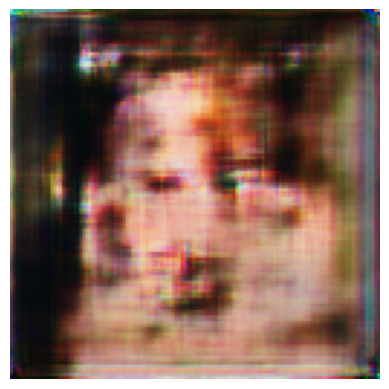

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<09:50,  2.53s/it]

ErrD: -3.705300807952881, ErrG: 17.1273250579834


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:26<08:58,  2.41s/it]

ErrD: -4.2201151847839355, ErrG: 33.4150390625


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:50<08:34,  2.40s/it]

ErrD: -5.221682071685791, ErrG: 29.871126174926758


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:14<08:01,  2.36s/it]

ErrD: -5.077605724334717, ErrG: 20.599609375


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:37<07:38,  2.36s/it]

ErrD: -5.769482135772705, ErrG: 8.243396759033203


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:01<07:09,  2.34s/it]

ErrD: -3.6076955795288086, ErrG: -31.61229705810547


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:24<06:47,  2.34s/it]

ErrD: -5.799075126647949, ErrG: -4.802623748779297


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [02:48<06:28,  2.37s/it]

ErrD: -5.440826416015625, ErrG: -17.084903717041016


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:11<05:59,  2.33s/it]

ErrD: -3.582265615463257, ErrG: -2.6610107421875


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [03:35<05:45,  2.40s/it]

ErrD: -5.440184593200684, ErrG: 17.772319793701172


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [03:59<05:12,  2.33s/it]

ErrD: -0.8663411140441895, ErrG: 25.776426315307617


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [04:22<04:45,  2.30s/it]

ErrD: -5.910826683044434, ErrG: 1.2071892023086548


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [04:45<04:26,  2.34s/it]

ErrD: -4.478813171386719, ErrG: -20.878334045410156


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:08<04:01,  2.33s/it]

ErrD: -4.968617916107178, ErrG: -4.744631767272949


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [05:32<03:37,  2.31s/it]

ErrD: -4.5280327796936035, ErrG: -25.350505828857422


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [05:55<03:13,  2.30s/it]

ErrD: -3.9653213024139404, ErrG: -13.220733642578125


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [06:18<02:48,  2.28s/it]

ErrD: -3.9103119373321533, ErrG: -7.957664489746094


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [06:41<02:28,  2.32s/it]

ErrD: -4.118719100952148, ErrG: -12.6956787109375


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [07:04<02:05,  2.33s/it]

ErrD: -3.871792793273926, ErrG: -9.07473087310791


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [07:27<01:39,  2.27s/it]

ErrD: -4.679224967956543, ErrG: -3.986830234527588


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [07:50<01:18,  2.29s/it]

ErrD: -3.685344696044922, ErrG: -12.078693389892578


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [08:13<00:55,  2.29s/it]

ErrD: -4.312102317810059, ErrG: 14.831230163574219


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [08:36<00:32,  2.31s/it]

ErrD: -3.890674591064453, ErrG: 30.878883361816406


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [08:59<00:09,  2.31s/it]

ErrD: -3.585127115249634, ErrG: -12.294448852539062


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [09:07<00:00,  2.33s/it]

ErrD: -3.827538013458252, ErrG: -14.427648544311523


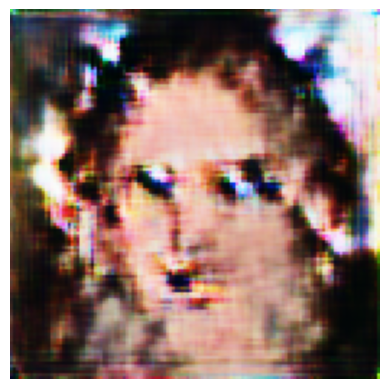

D(
  (D): ModuleList(
    (0): WSConv2d(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): WSConv2d(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (5): WSConv2d(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): LeakyReLU(negative_slope=0.2)
    (7): WSConv2d(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (8): LeakyReLU(negative_slope=0.2)
    (9): Avgpool(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (10): WSConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): WSConv2d(
      (conv

Epoch 1/2:   0%|▎                                                                    | 1/235 [00:22<1:28:19, 22.65s/it]

ErrD: -20.327648162841797, ErrG: -13.258222579956055


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:53<11:10,  2.99s/it]

ErrD: -281.4002380371094, ErrG: -60.129554748535156


Epoch 1/2:   9%|██████▎                                                               | 21/235 [01:20<09:43,  2.73s/it]

ErrD: -1358.780517578125, ErrG: 660.8487548828125


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:48<09:21,  2.75s/it]

ErrD: -1599.5166015625, ErrG: 294.8201904296875


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [02:15<09:00,  2.79s/it]

ErrD: -1739.4107666015625, ErrG: -568.4781494140625


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:43<08:34,  2.80s/it]

ErrD: -3254.21484375, ErrG: 1107.6051025390625


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [03:11<08:01,  2.77s/it]

ErrD: -2992.4150390625, ErrG: 941.268310546875


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [03:38<07:28,  2.74s/it]

ErrD: -2845.761962890625, ErrG: 1260.260986328125


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [04:06<07:01,  2.74s/it]

ErrD: -2682.572265625, ErrG: 901.2396240234375


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [04:34<06:36,  2.76s/it]

ErrD: -3673.108642578125, ErrG: 1047.5152587890625


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [05:02<06:11,  2.77s/it]

ErrD: -3315.04248046875, ErrG: 266.5396728515625


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [05:29<05:44,  2.78s/it]

ErrD: -3386.80615234375, ErrG: 736.8831787109375


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:57<05:18,  2.79s/it]

ErrD: -3288.28173828125, ErrG: 737.0288696289062


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [06:24<04:44,  2.74s/it]

ErrD: -3370.462890625, ErrG: 997.6949462890625


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:52<04:21,  2.78s/it]

ErrD: -957.83935546875, ErrG: 6.845241546630859


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [07:19<03:48,  2.72s/it]

ErrD: -1674.9014892578125, ErrG: 931.2861328125


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:46<03:21,  2.73s/it]

ErrD: 137.358642578125, ErrG: -388.2763977050781


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [08:13<02:51,  2.68s/it]

ErrD: -51.97455596923828, ErrG: -259.08880615234375


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:41<02:29,  2.78s/it]

ErrD: 155.26327514648438, ErrG: -134.79576110839844


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [09:08<02:01,  2.77s/it]

ErrD: 4.667328357696533, ErrG: -96.53173065185547


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:36<01:34,  2.78s/it]

ErrD: -9.32331371307373, ErrG: -70.60179138183594


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [10:03<01:05,  2.71s/it]

ErrD: -6.093950271606445, ErrG: -29.451751708984375


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [10:30<00:38,  2.75s/it]

ErrD: -6.929959297180176, ErrG: -45.955543518066406


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:58<00:11,  2.79s/it]

ErrD: -71.5664291381836, ErrG: -170.80548095703125


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [11:15<00:00,  2.87s/it]

ErrD: -141.5893096923828, ErrG: -260.7377014160156


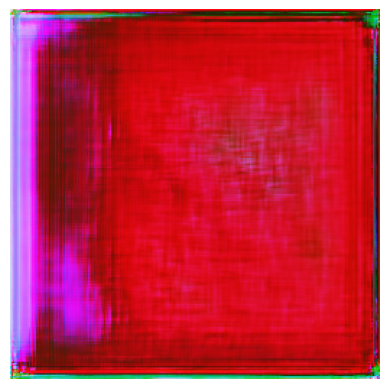

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:04<15:40,  4.02s/it]

ErrD: -158.55726623535156, ErrG: -281.5182189941406


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:31<10:13,  2.74s/it]

ErrD: -300.3345947265625, ErrG: -416.1649169921875


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:59<09:49,  2.75s/it]

ErrD: -451.2923583984375, ErrG: -157.447509765625


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:26<09:24,  2.76s/it]

ErrD: -676.7344970703125, ErrG: 264.779296875


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:54<08:51,  2.74s/it]

ErrD: 24.719451904296875, ErrG: 76.44084930419922


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:21<08:29,  2.77s/it]

ErrD: -50.546546936035156, ErrG: -68.82211303710938


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:48<08:01,  2.77s/it]

ErrD: -27.39148712158203, ErrG: 193.06890869140625


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:16<07:23,  2.71s/it]

ErrD: -88.90678405761719, ErrG: 112.28936767578125


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:43<07:04,  2.76s/it]

ErrD: -75.1817855834961, ErrG: 57.70103454589844


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [04:11<06:48,  2.83s/it]

ErrD: -37.98664093017578, ErrG: 26.023971557617188


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:39<06:14,  2.79s/it]

ErrD: -40.75941848754883, ErrG: 12.1735258102417


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [05:06<05:44,  2.78s/it]

ErrD: 12.224874496459961, ErrG: -24.900432586669922


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:34<05:13,  2.75s/it]

ErrD: -2.180797576904297, ErrG: -1.5658684968948364


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [06:02<04:45,  2.74s/it]

ErrD: -8.829625129699707, ErrG: -22.03826904296875


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:29<04:17,  2.74s/it]

ErrD: -17.66436004638672, ErrG: -29.777429580688477


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:56<03:47,  2.71s/it]

ErrD: -11.125296592712402, ErrG: -21.642183303833008


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:24<03:20,  2.71s/it]

ErrD: -3.8811874389648438, ErrG: -2.5522754192352295


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:51<02:51,  2.67s/it]

ErrD: -1.5145035982131958, ErrG: -7.537693500518799


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:18<02:28,  2.74s/it]

ErrD: -6.762246608734131, ErrG: 2.3420796394348145


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:45<01:59,  2.72s/it]

ErrD: -3.432631015777588, ErrG: 4.598918914794922


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:13<01:32,  2.73s/it]

ErrD: -2.782705783843994, ErrG: -19.409141540527344


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:40<01:05,  2.72s/it]

ErrD: -1.6528575420379639, ErrG: -57.840633392333984


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [10:07<00:38,  2.74s/it]

ErrD: -3.2375802993774414, ErrG: -45.90278625488281


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:35<00:11,  2.76s/it]

ErrD: -7.201902389526367, ErrG: -25.417993545532227


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:45<00:00,  2.75s/it]

ErrD: -5.656923294067383, ErrG: -48.46410369873047


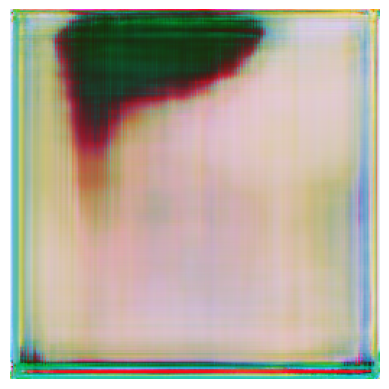

Epoch 1/2:   0%|▎                                                                      | 1/235 [00:02<10:59,  2.82s/it]

ErrD: -2.420952081680298, ErrG: 61.64656066894531


Epoch 1/2:   5%|███▎                                                                  | 11/235 [00:30<10:13,  2.74s/it]

ErrD: -2.0141379833221436, ErrG: 52.38648223876953


Epoch 1/2:   9%|██████▎                                                               | 21/235 [00:57<09:46,  2.74s/it]

ErrD: -5.855319023132324, ErrG: 28.051437377929688


Epoch 1/2:  13%|█████████▏                                                            | 31/235 [01:24<09:13,  2.71s/it]

ErrD: -2.7654523849487305, ErrG: 71.3145523071289


Epoch 1/2:  17%|████████████▏                                                         | 41/235 [01:52<08:52,  2.74s/it]

ErrD: -8.22645378112793, ErrG: 55.614158630371094


Epoch 1/2:  22%|███████████████▏                                                      | 51/235 [02:19<08:21,  2.72s/it]

ErrD: -7.757157325744629, ErrG: 67.2740249633789


Epoch 1/2:  26%|██████████████████▏                                                   | 61/235 [02:47<08:12,  2.83s/it]

ErrD: -8.188882827758789, ErrG: 76.20402526855469


Epoch 1/2:  30%|█████████████████████▏                                                | 71/235 [03:14<07:33,  2.76s/it]

ErrD: -7.938849449157715, ErrG: 46.90979766845703


Epoch 1/2:  34%|████████████████████████▏                                             | 81/235 [03:42<07:04,  2.76s/it]

ErrD: -10.642467498779297, ErrG: 41.94976806640625


Epoch 1/2:  39%|███████████████████████████                                           | 91/235 [04:10<06:43,  2.80s/it]

ErrD: -0.10570240020751953, ErrG: 128.1284942626953


Epoch 1/2:  43%|█████████████████████████████▋                                       | 101/235 [04:38<06:07,  2.75s/it]

ErrD: -12.654425621032715, ErrG: 13.613351821899414


Epoch 1/2:  47%|████████████████████████████████▌                                    | 111/235 [05:05<05:41,  2.75s/it]

ErrD: -14.462026596069336, ErrG: 30.795106887817383


Epoch 1/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:32<05:10,  2.72s/it]

ErrD: -10.240320205688477, ErrG: 119.98849487304688


Epoch 1/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:59<04:41,  2.71s/it]

ErrD: -15.164789199829102, ErrG: 37.232460021972656


Epoch 1/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:27<04:16,  2.73s/it]

ErrD: -16.891738891601562, ErrG: 62.896644592285156


Epoch 1/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:53<03:43,  2.66s/it]

ErrD: -9.212881088256836, ErrG: 63.671695709228516


Epoch 1/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:20<03:16,  2.65s/it]

ErrD: -12.564966201782227, ErrG: 80.27302551269531


Epoch 1/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:47<02:51,  2.68s/it]

ErrD: -8.256708145141602, ErrG: 79.32472229003906


Epoch 1/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:14<02:25,  2.70s/it]

ErrD: -19.016761779785156, ErrG: 65.99456024169922


Epoch 1/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:40<01:57,  2.68s/it]

ErrD: -12.868711471557617, ErrG: 75.97606658935547


Epoch 1/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:07<01:31,  2.69s/it]

ErrD: -14.973855018615723, ErrG: 43.18336868286133


Epoch 1/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:34<01:03,  2.65s/it]

ErrD: -6.579769611358643, ErrG: 90.29911804199219


Epoch 1/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [10:00<00:37,  2.66s/it]

ErrD: -14.960671424865723, ErrG: 13.360153198242188


Epoch 1/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:27<00:10,  2.71s/it]

ErrD: -9.802757263183594, ErrG: 64.35281372070312


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:37<00:00,  2.71s/it]

ErrD: -4.493435382843018, ErrG: 76.86819458007812


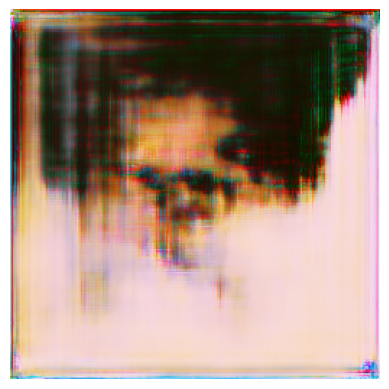

Epoch 2/2:   0%|▎                                                                      | 1/235 [00:02<10:46,  2.76s/it]

ErrD: -4.672969818115234, ErrG: -54.92477035522461


Epoch 2/2:   5%|███▎                                                                  | 11/235 [00:30<10:10,  2.72s/it]

ErrD: -6.612725257873535, ErrG: 10.14893913269043


Epoch 2/2:   9%|██████▎                                                               | 21/235 [00:57<09:45,  2.73s/it]

ErrD: -9.332480430603027, ErrG: 19.17224884033203


Epoch 2/2:  13%|█████████▏                                                            | 31/235 [01:24<09:12,  2.71s/it]

ErrD: -10.646081924438477, ErrG: 3.06205415725708


Epoch 2/2:  17%|████████████▏                                                         | 41/235 [01:52<08:47,  2.72s/it]

ErrD: -10.207160949707031, ErrG: 80.88505554199219


Epoch 2/2:  22%|███████████████▏                                                      | 51/235 [02:19<08:22,  2.73s/it]

ErrD: -10.513455390930176, ErrG: 27.03314971923828


Epoch 2/2:  26%|██████████████████▏                                                   | 61/235 [02:46<07:55,  2.73s/it]

ErrD: -7.154623985290527, ErrG: 26.94149398803711


Epoch 2/2:  30%|█████████████████████▏                                                | 71/235 [03:13<07:29,  2.74s/it]

ErrD: -1.5677227973937988, ErrG: -58.430572509765625


Epoch 2/2:  34%|████████████████████████▏                                             | 81/235 [03:40<06:54,  2.69s/it]

ErrD: -8.526123046875, ErrG: -14.634393692016602


Epoch 2/2:  39%|███████████████████████████                                           | 91/235 [04:07<06:30,  2.71s/it]

ErrD: -5.609307289123535, ErrG: -39.349342346191406


Epoch 2/2:  43%|█████████████████████████████▋                                       | 101/235 [04:35<06:05,  2.72s/it]

ErrD: -5.128811359405518, ErrG: -15.911741256713867


Epoch 2/2:  47%|████████████████████████████████▌                                    | 111/235 [05:02<05:37,  2.72s/it]

ErrD: -2.794220447540283, ErrG: -75.77284240722656


Epoch 2/2:  51%|███████████████████████████████████▌                                 | 121/235 [05:29<05:09,  2.71s/it]

ErrD: -0.3449278175830841, ErrG: 7.675394058227539


Epoch 2/2:  56%|██████████████████████████████████████▍                              | 131/235 [05:57<04:44,  2.74s/it]

ErrD: -9.727926254272461, ErrG: 10.564433097839355


Epoch 2/2:  60%|█████████████████████████████████████████▍                           | 141/235 [06:24<04:17,  2.74s/it]

ErrD: -6.1274189949035645, ErrG: 8.562637329101562


Epoch 2/2:  64%|████████████████████████████████████████████▎                        | 151/235 [06:50<03:43,  2.66s/it]

ErrD: -3.3412933349609375, ErrG: 16.93243408203125


Epoch 2/2:  69%|███████████████████████████████████████████████▎                     | 161/235 [07:17<03:17,  2.67s/it]

ErrD: -3.6238441467285156, ErrG: 15.198192596435547


Epoch 2/2:  73%|██████████████████████████████████████████████████▏                  | 171/235 [07:43<02:50,  2.67s/it]

ErrD: 0.09561502933502197, ErrG: -26.75107192993164


Epoch 2/2:  77%|█████████████████████████████████████████████████████▏               | 181/235 [08:10<02:23,  2.65s/it]

ErrD: -2.41489577293396, ErrG: -28.69516372680664


Epoch 2/2:  81%|████████████████████████████████████████████████████████             | 191/235 [08:37<01:58,  2.69s/it]

ErrD: -4.766247272491455, ErrG: -16.527984619140625


Epoch 2/2:  86%|███████████████████████████████████████████████████████████          | 201/235 [09:04<01:31,  2.70s/it]

ErrD: -4.370197296142578, ErrG: -19.346698760986328


Epoch 2/2:  90%|█████████████████████████████████████████████████████████████▉       | 211/235 [09:31<01:05,  2.71s/it]

ErrD: -3.271573543548584, ErrG: -17.427457809448242


Epoch 2/2:  94%|████████████████████████████████████████████████████████████████▉    | 221/235 [09:59<00:38,  2.74s/it]

ErrD: -7.616633892059326, ErrG: -22.408361434936523


Epoch 2/2:  98%|███████████████████████████████████████████████████████████████████▊ | 231/235 [10:26<00:10,  2.73s/it]

ErrD: -7.996531963348389, ErrG: -12.237675666809082


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████| 235/235 [10:36<00:00,  2.71s/it]

ErrD: -4.987588882446289, ErrG: 0.37849825620651245


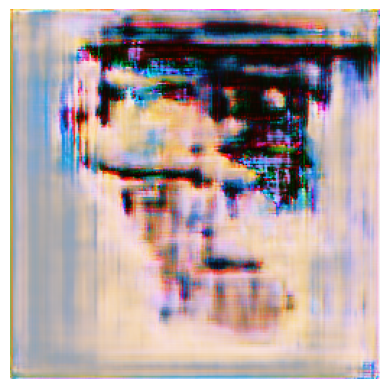

In [169]:
image_size = 256
path = "datasets/celeba_hq"
model_path = "checkpoints"
transform = [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
g_lr = 1e-3
d_lr = 1e-3
num_epochs = 2
batch_size = 128
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gan = ProGAN(256, image_size, device)
torch.backends.cudnn.benchmark = True
G_losses, D_losses = gan.train(path, model_path, transform, g_lr, d_lr, num_epochs, batch_size, image_size, device)

In [170]:
loader = DatasetLoader(path, batch_size, transforms.Compose(transform + [transforms.Resize(image_size, antialias=None)]))
data = iter(loader.getDataloader())
print(gan.D(next(data)[0].cuda(), 1.0, True))
print(gan.D(gan.G(torch.randn(batch_size, 256, 1, 1).cuda(), 1.0, True), 1.0, True))

tensor([[[[10.4964]]],


        [[[12.0333]]],


        [[[11.8102]]],


        [[[ 1.2264]]],


        [[[ 7.4325]]],


        [[[15.3164]]],


        [[[-3.9571]]],


        [[[19.3019]]],


        [[[ 8.8081]]],


        [[[ 6.5304]]],


        [[[ 2.4616]]],


        [[[10.6313]]],


        [[[14.8251]]],


        [[[ 9.2428]]],


        [[[ 7.8816]]],


        [[[ 4.5834]]],


        [[[12.0579]]],


        [[[ 7.9812]]],


        [[[15.3619]]],


        [[[11.4187]]],


        [[[-1.8000]]],


        [[[10.6685]]],


        [[[ 5.9190]]],


        [[[14.1453]]],


        [[[10.8939]]],


        [[[ 6.3709]]],


        [[[ 2.8998]]],


        [[[ 9.4172]]],


        [[[ 8.5485]]],


        [[[ 1.9714]]],


        [[[14.3366]]],


        [[[14.0924]]],


        [[[ 9.2781]]],


        [[[12.2295]]],


        [[[11.2371]]],


        [[[11.0724]]],


        [[[15.9802]]],


        [[[10.1935]]],


        [[[ 4.8274]]],


        [[[-2.2250]]],




In [171]:
import torchvision.utils as vutils
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    image = image * 0.5 + 0.5
    plt.figure()
    plt.imshow(vutils.make_grid(image.cpu(), padding=2, normalize=True).permute(1, 2, 0))
    plt.grid('off')
    plt.axis('off')
    plt.show()

plot_image(gan(torch.randn(1, 256, 1, 1, device=device)))

TypeError: 'ProGAN' object is not callable

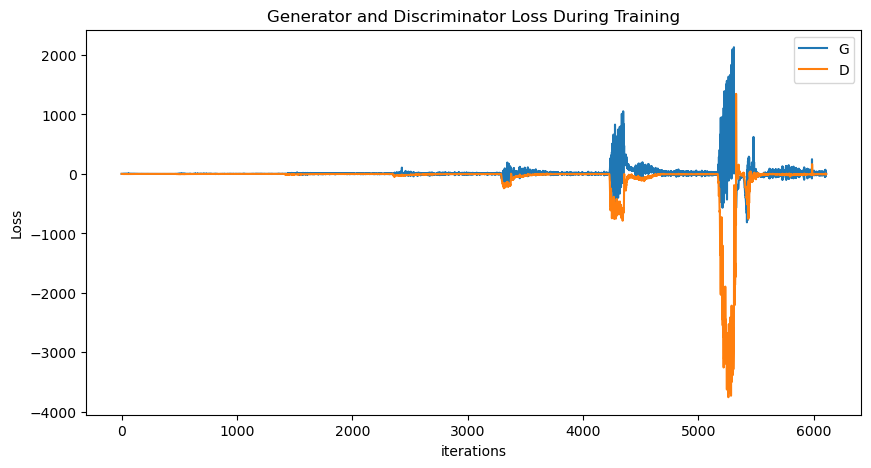

In [173]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#https://medium.com/dejunhuang/implementing-gan-and-wgan-in-pytorch-551099afde3c
#https://github.com/martinarjovsky/WassersteinGAN/blob/master/models/dcgan.py